In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor
import utils as u

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading meme data

In [2]:
gaming_df = pd.read_csv('../data/processed/gaming.csv')

print(gaming_df.shape)
gaming_df.head()

(125654, 10)


timestamp      open      high       low     close        volume    name  \
0  1639526400  4.744375  5.317031  2.173027  3.078208  1.480910e+06  SENATE   
1  1639612800  3.090095  3.299374  2.405868  2.605501  6.657927e+05  SENATE   
2  1639699200  2.625207  3.096436  2.283871  2.741340  5.401045e+05  SENATE   
3  1639785600  2.771380  3.038297  2.604262  2.720898  2.294669e+05  SENATE   
4  1639872000  2.726673  2.815944  2.498097  2.724654  1.654344e+05  SENATE   

   symbol                                    id category  
0  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
1  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
2  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
3  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming  
4  SENATE  0432c2ca-0dc4-44c5-bf0c-a2feaa4b3130   gaming

## Preprocessing data

In [3]:
days_to_predict = 7
train_data, test_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler= u.preprocess(gaming_df, days_to_predict=7)

In [4]:
forecaster = u.train_forecaster(series_dict, exog_dict)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2865
[LightGBM] [Info] Number of data points in the train set: 80319, number of used features: 12
[LightGBM] [Info] Start training from score 0.000875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [5]:
predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=forecaster, future_exog_dict=future_exog_dict)

In [6]:
og_train, og_test, og_pred = u.inverse_scaling(train_df=train_data, test_df=test_data, pred_df=predictions, series_scaler=series_scaler)

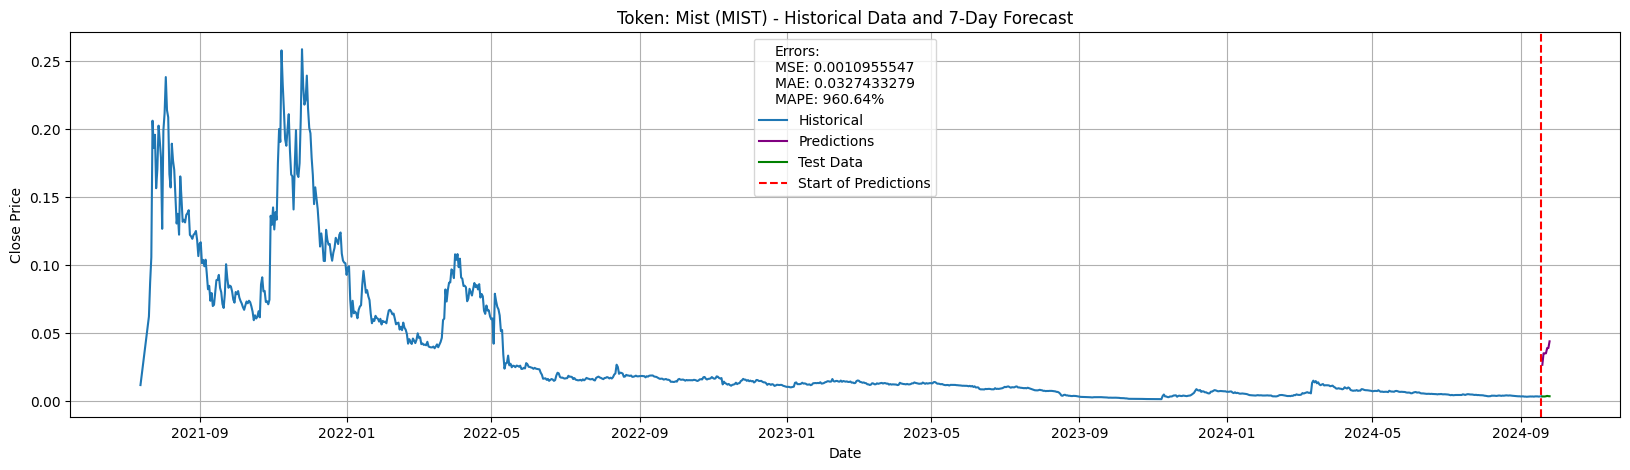

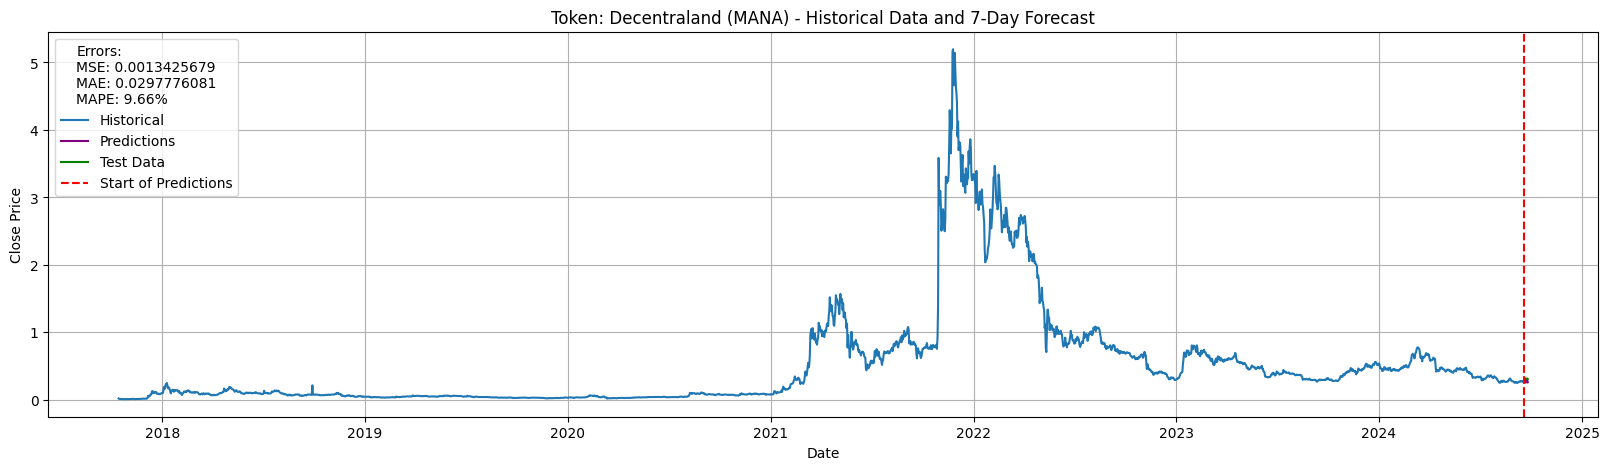

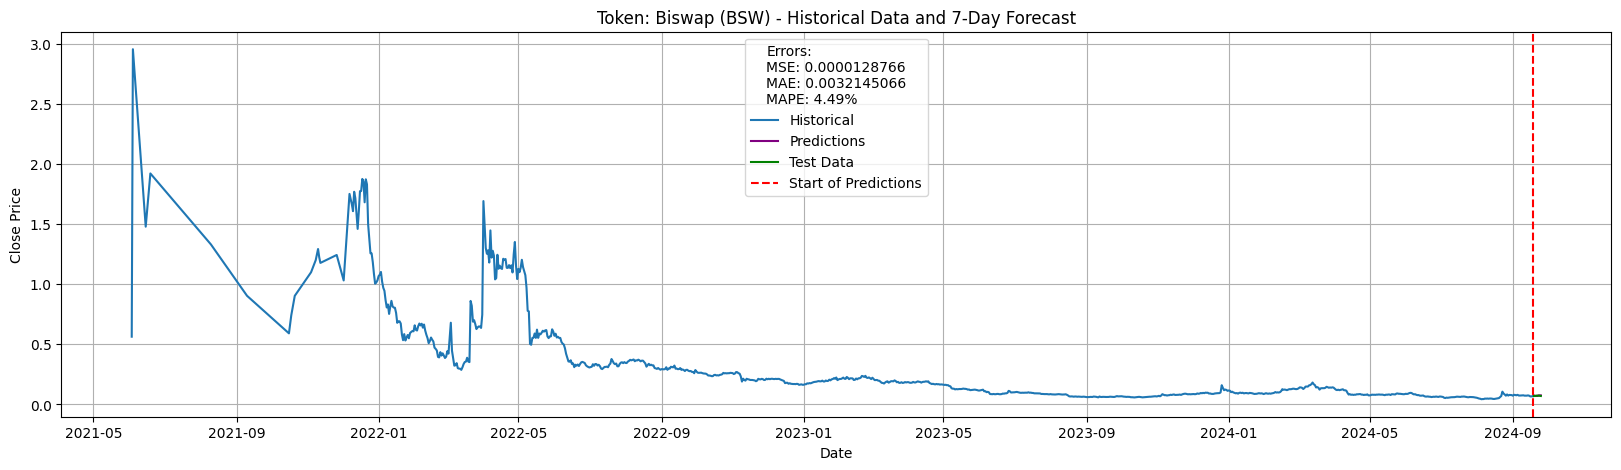

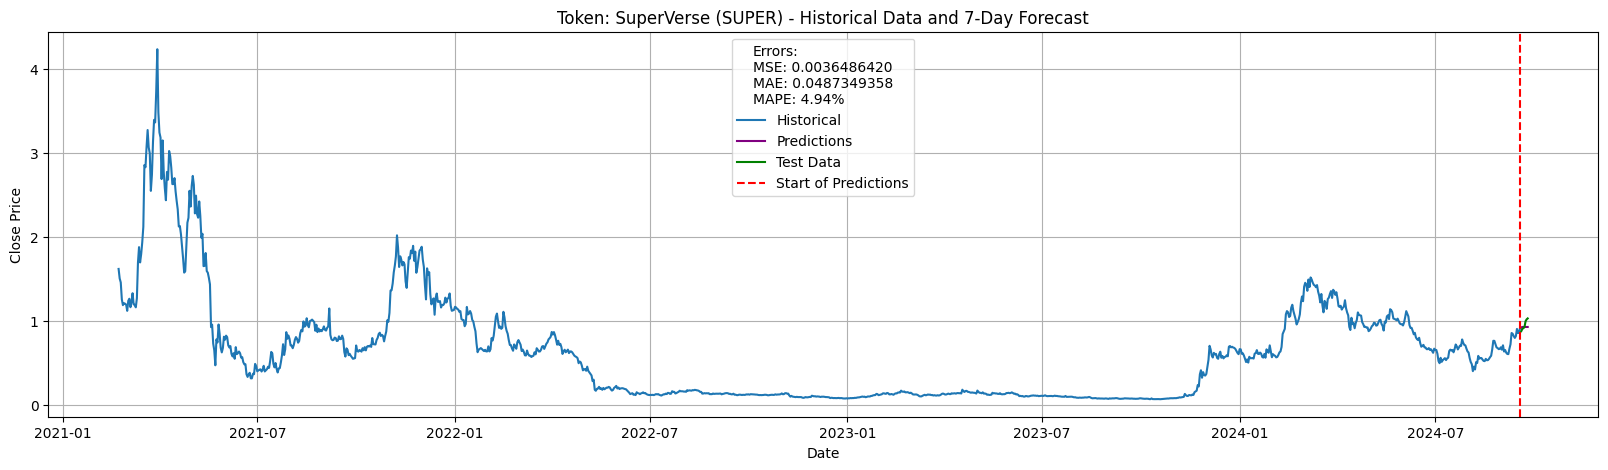

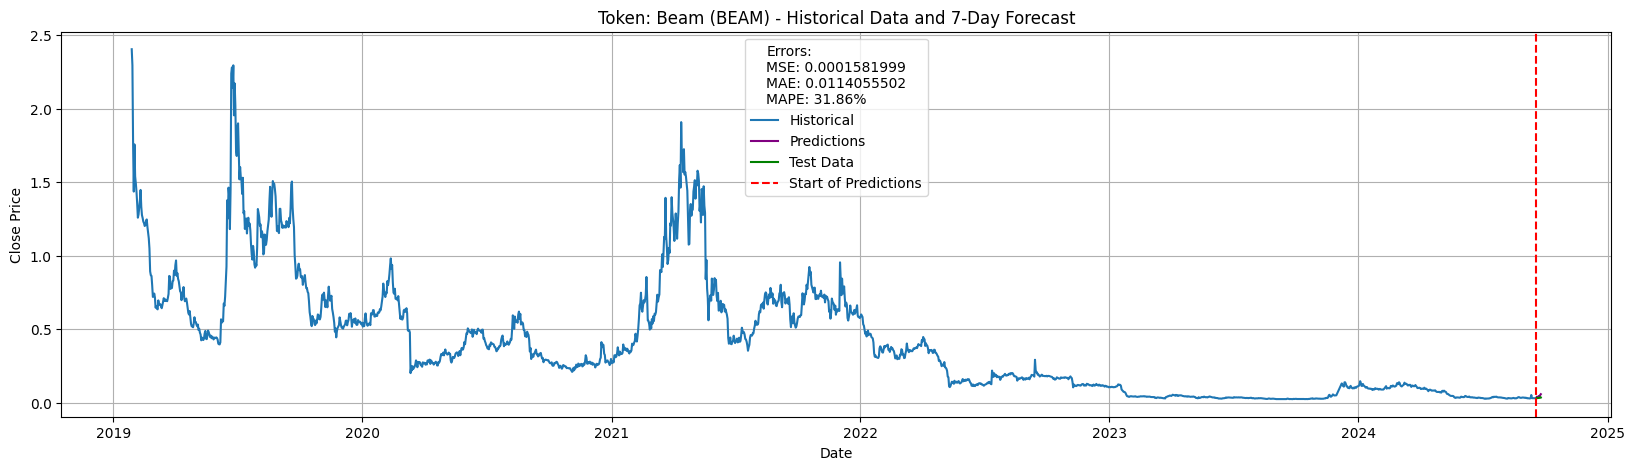

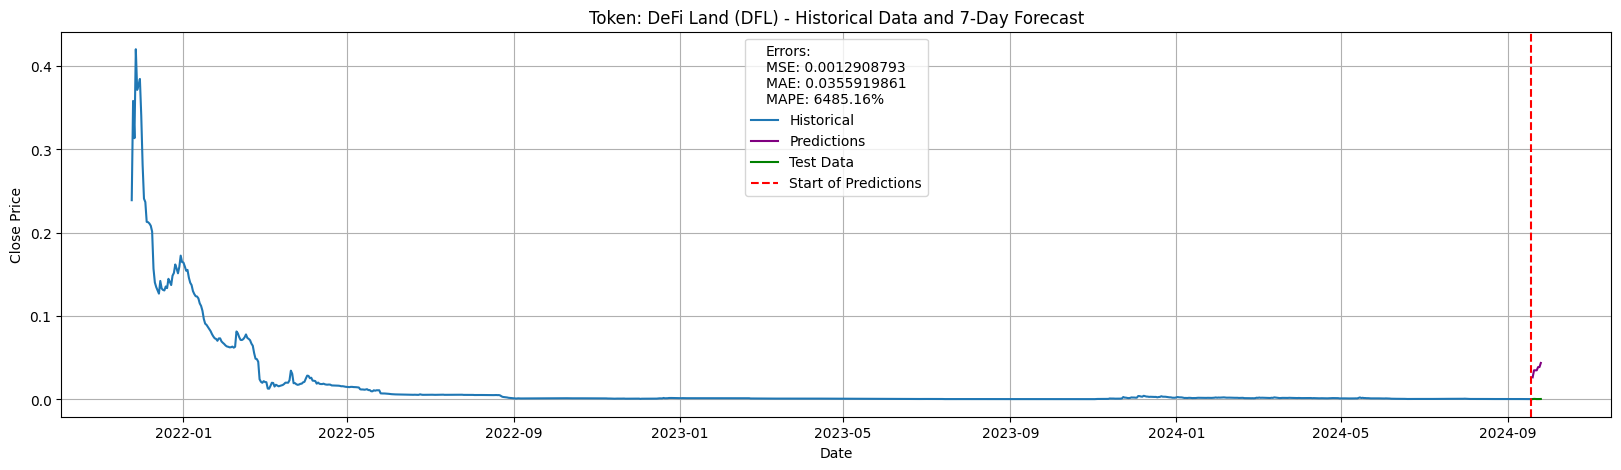

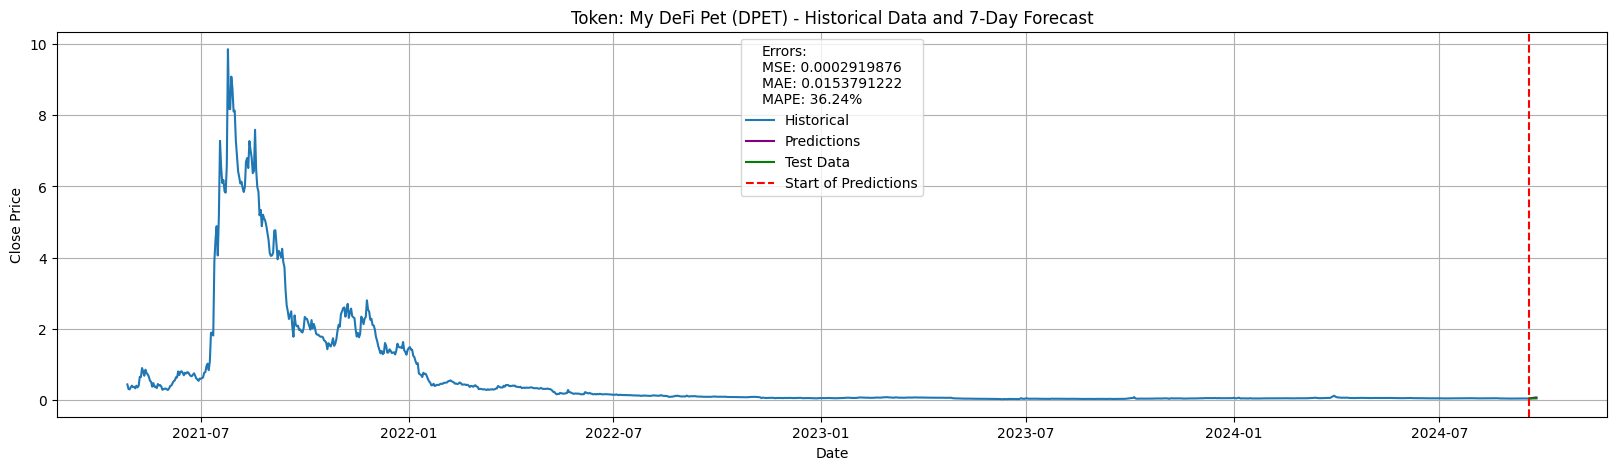

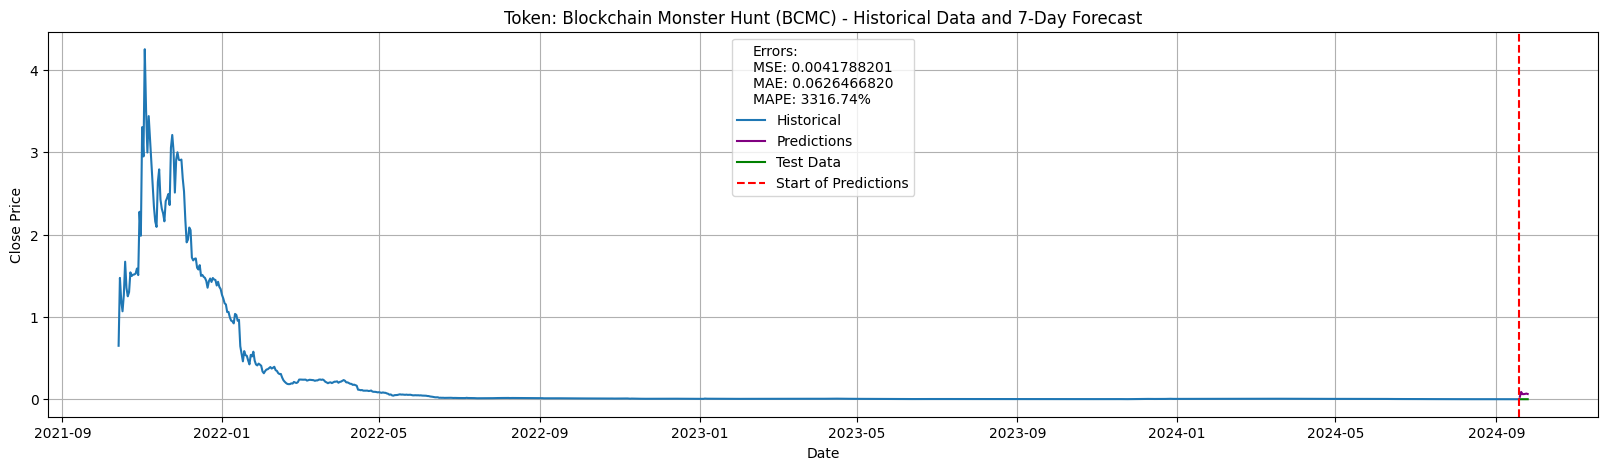

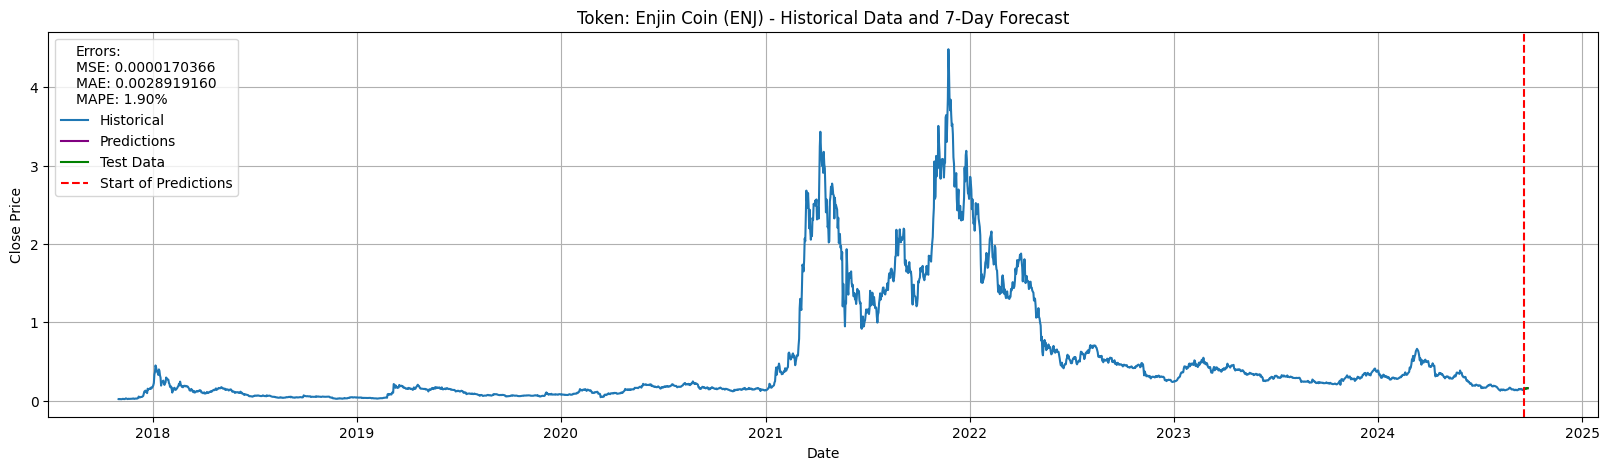

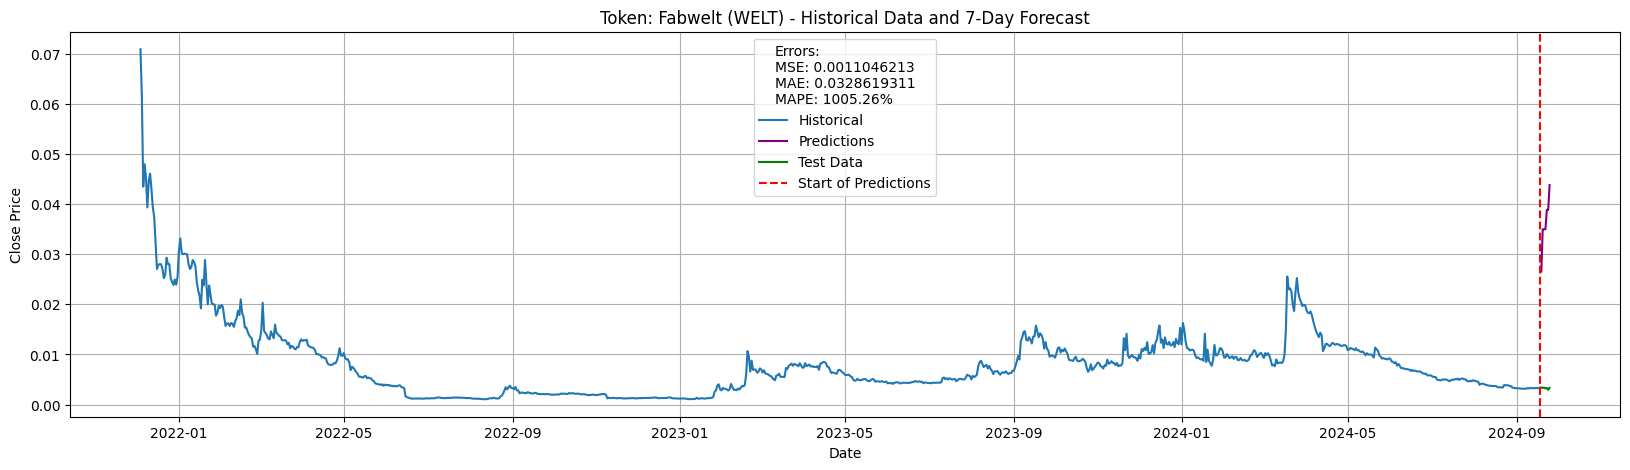

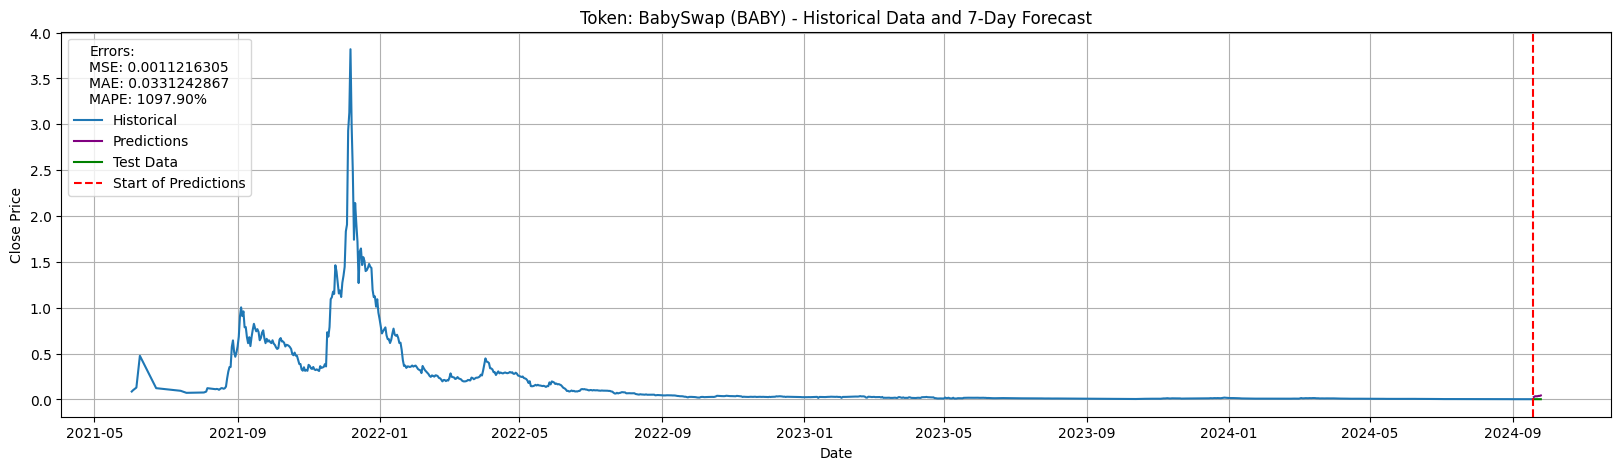

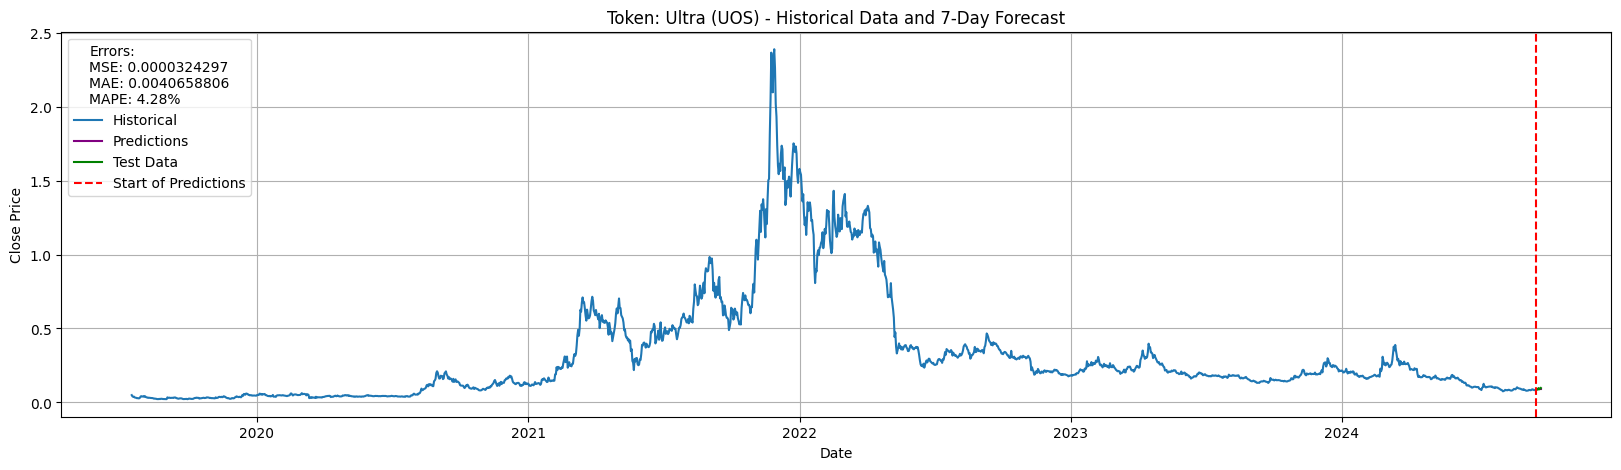

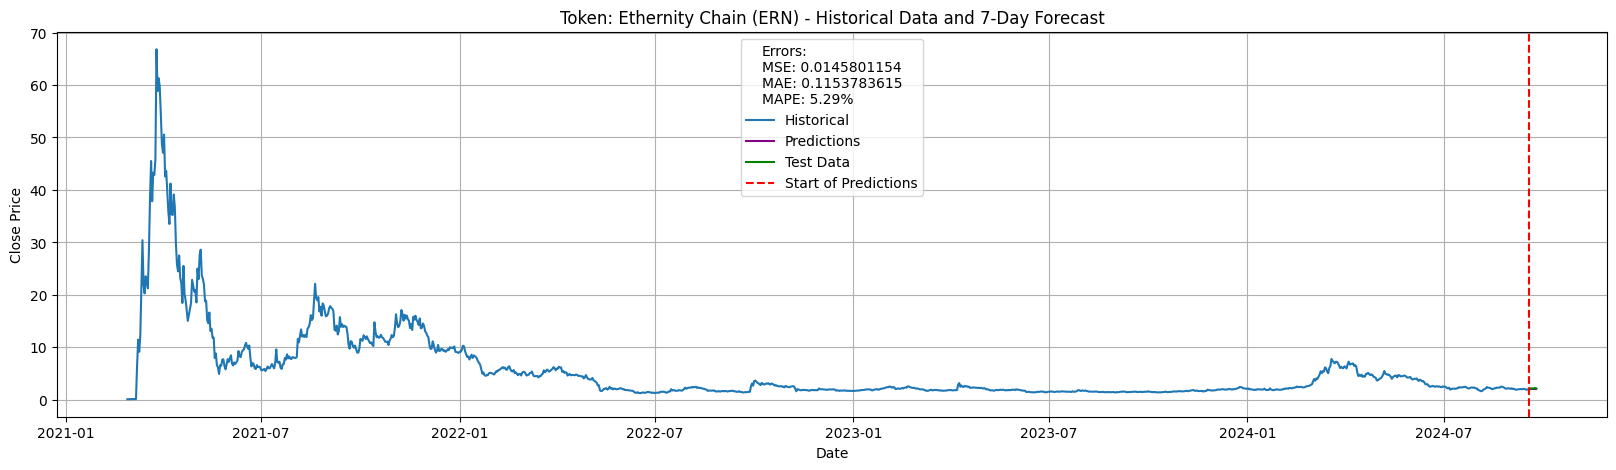

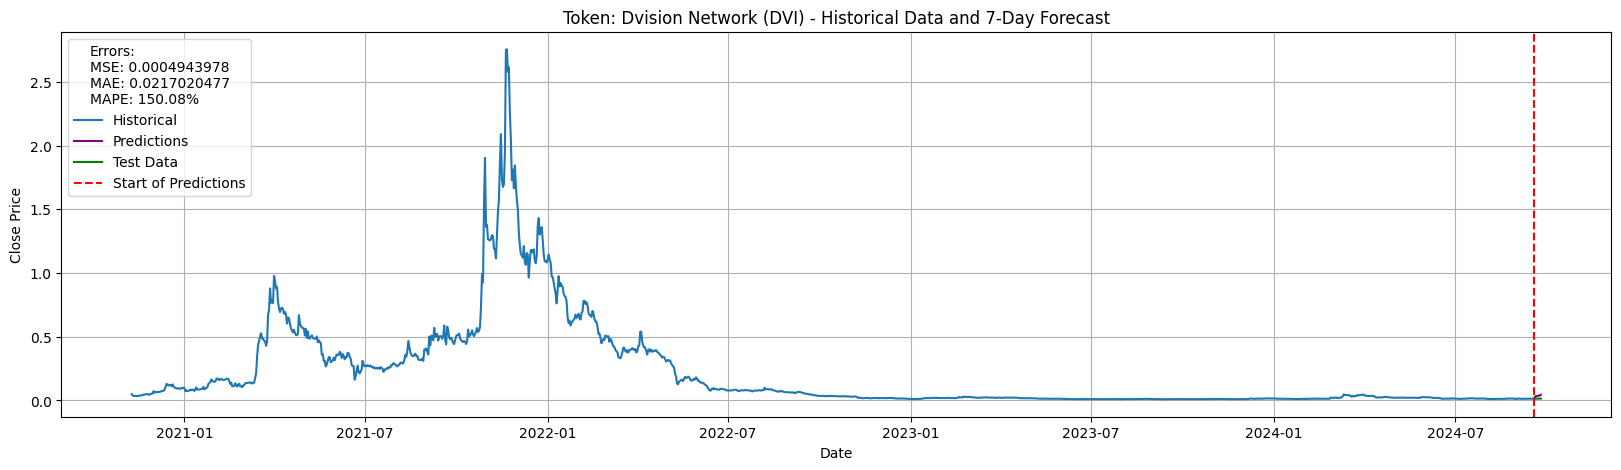

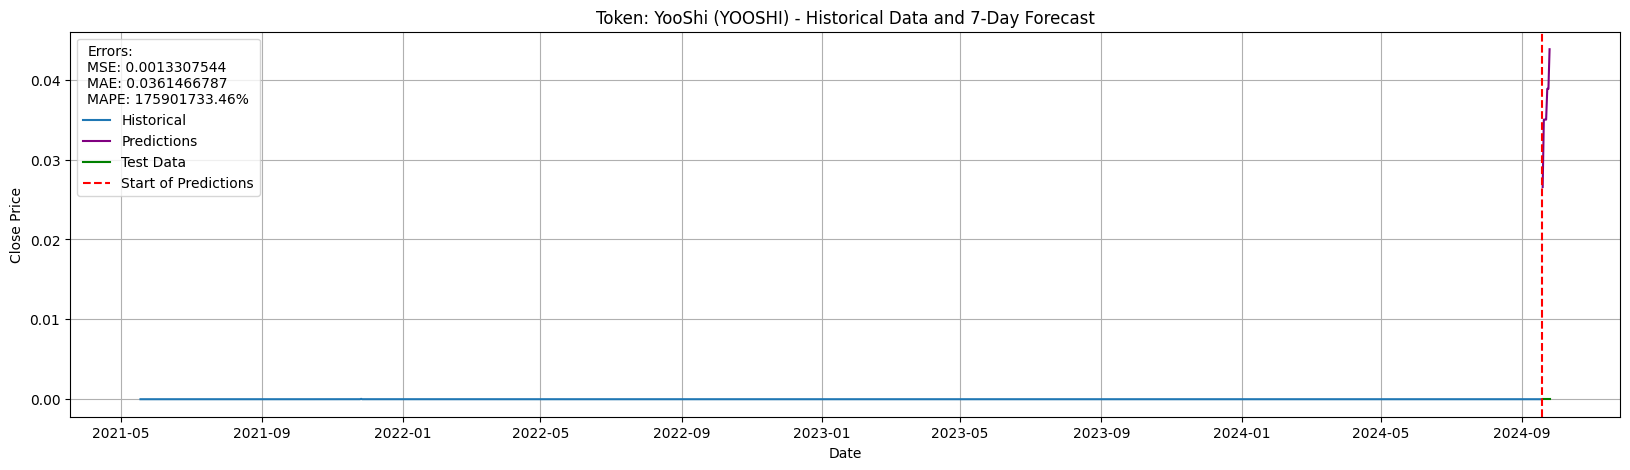

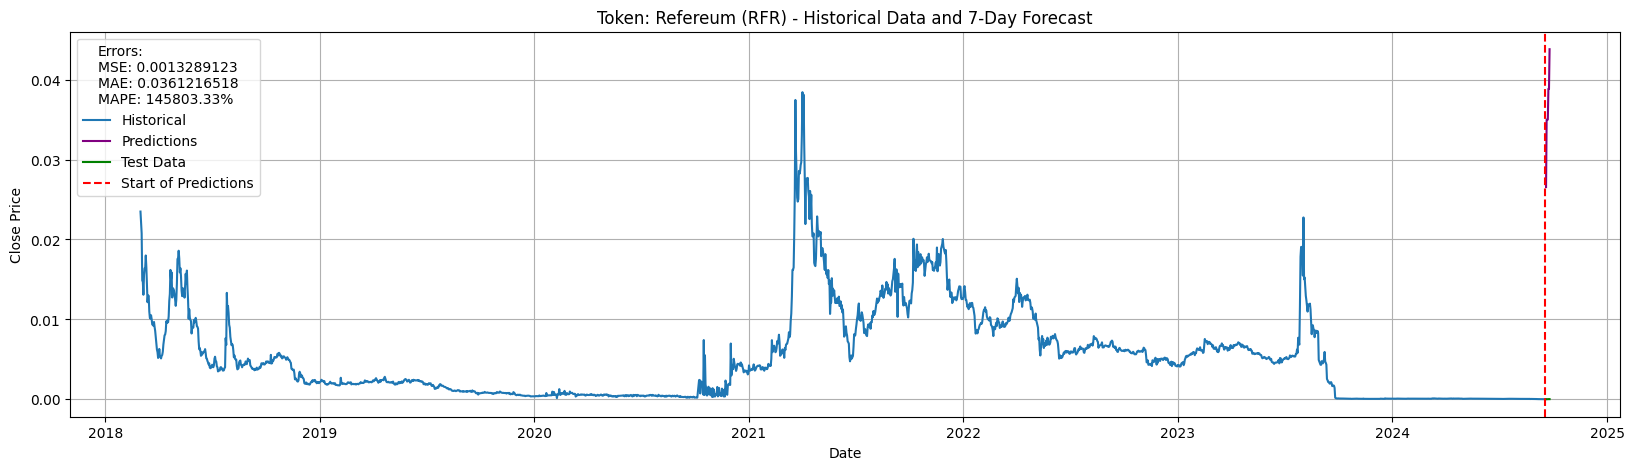

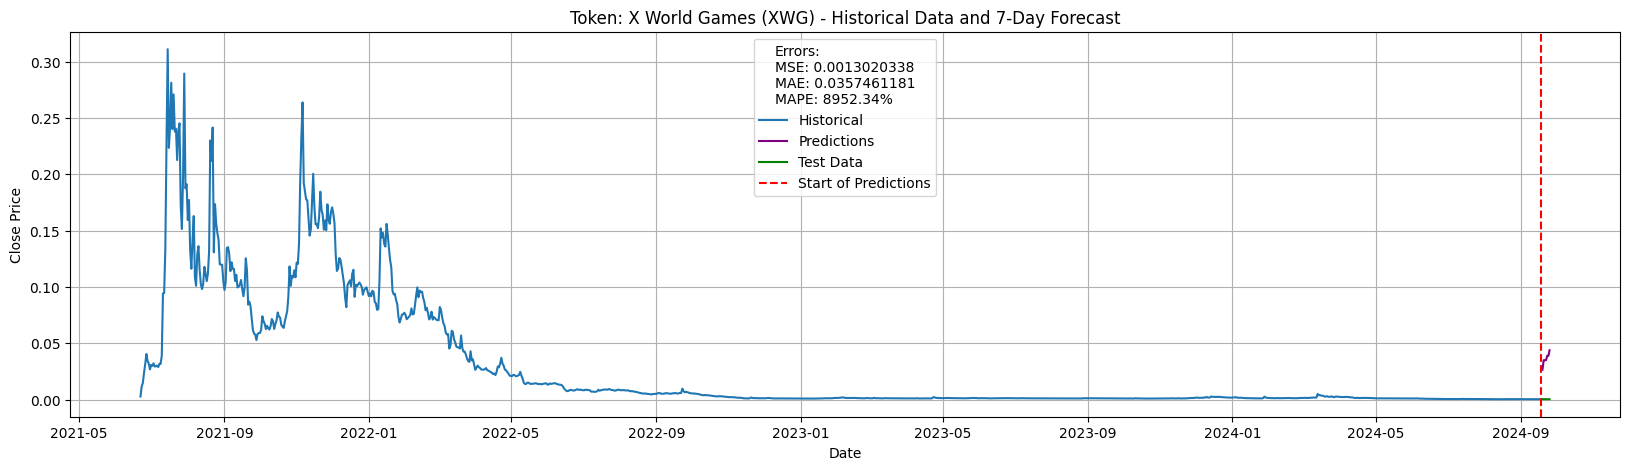

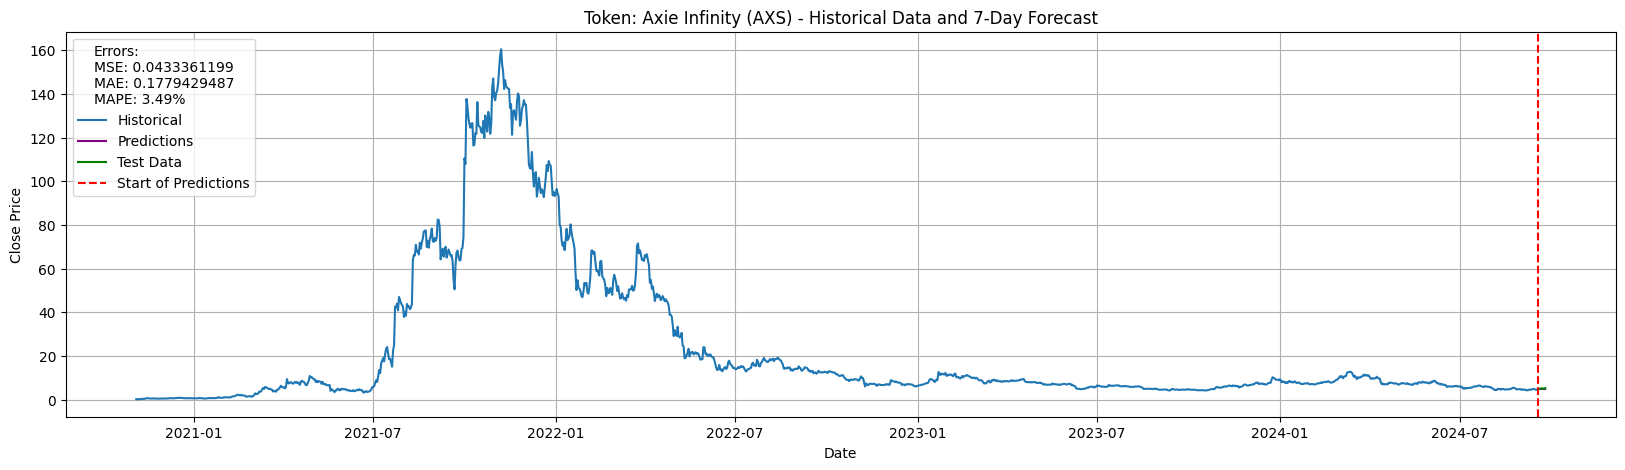

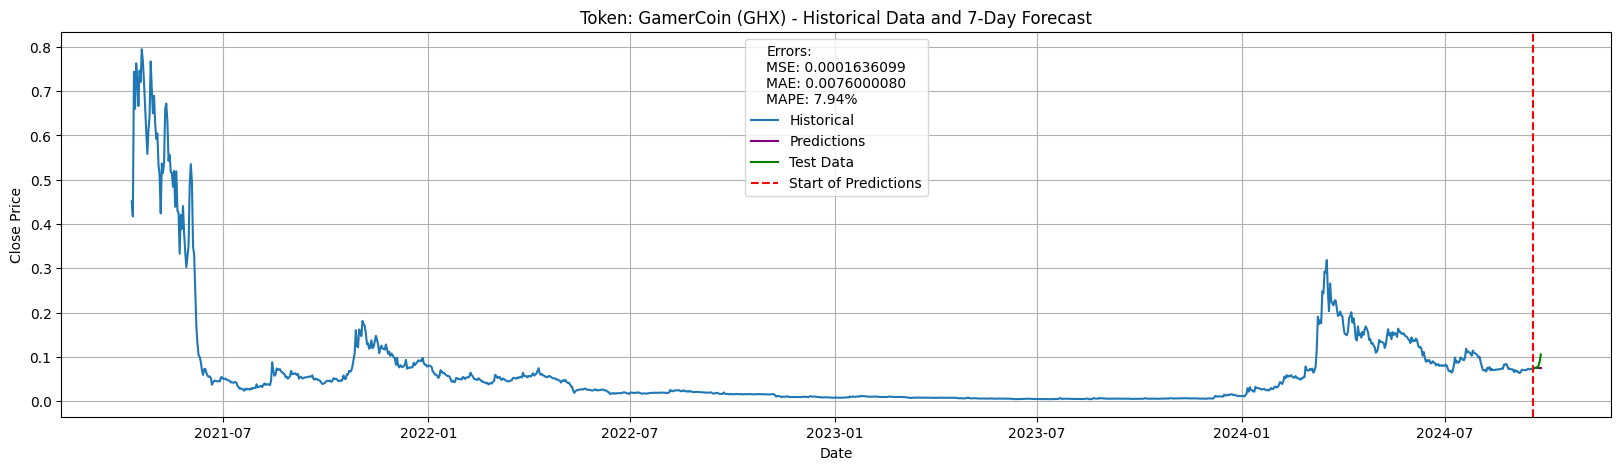

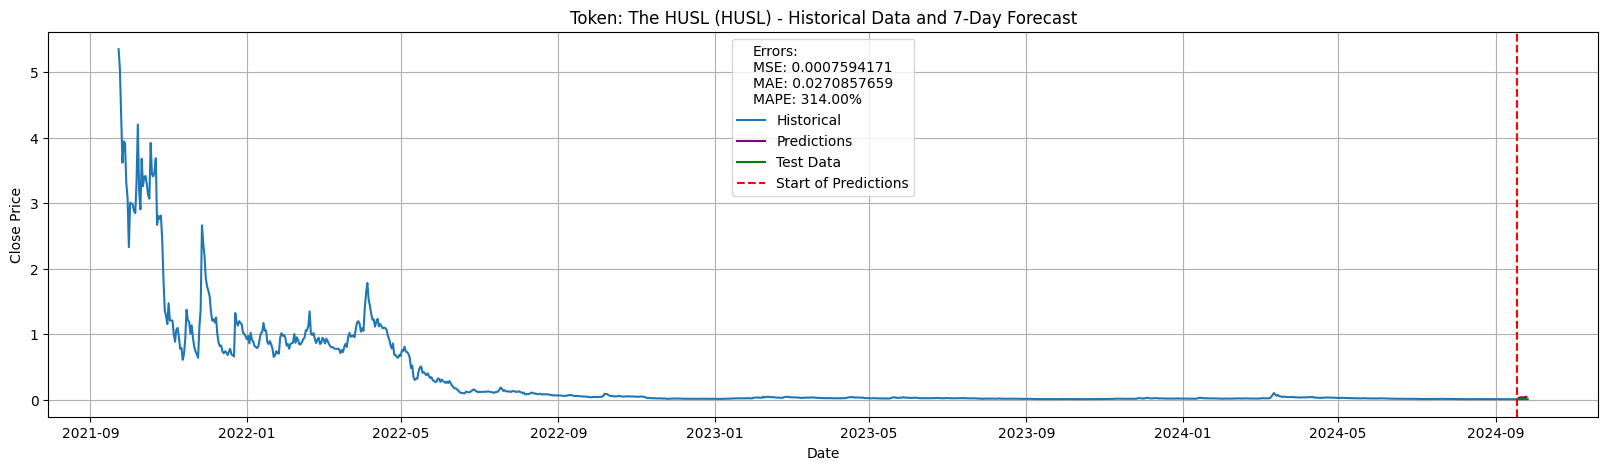

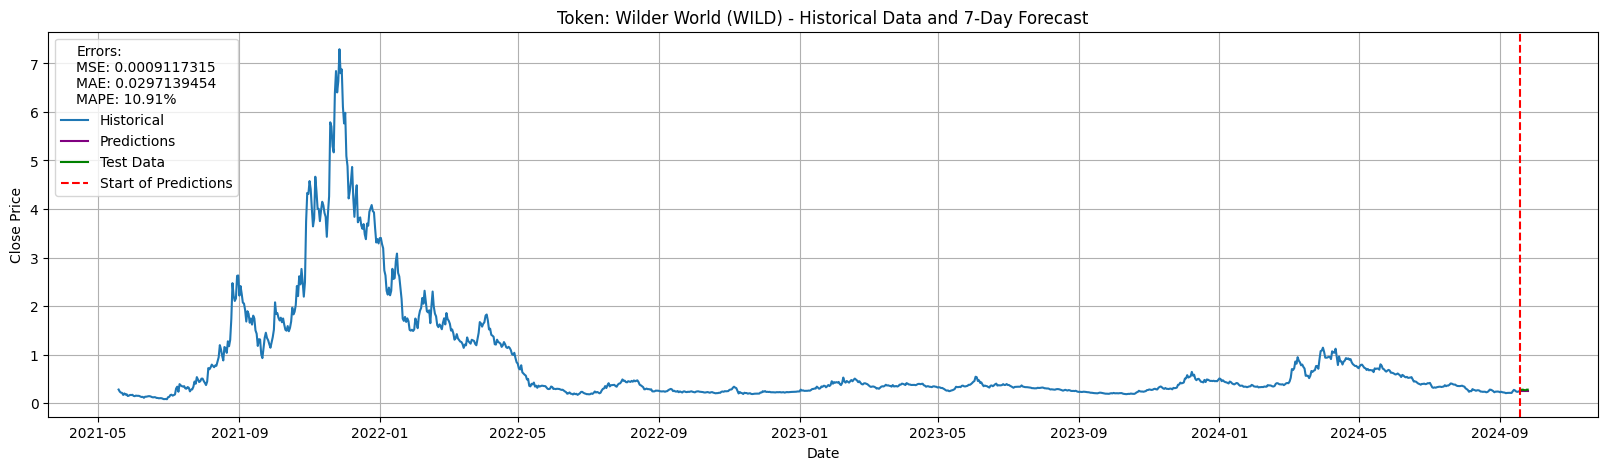

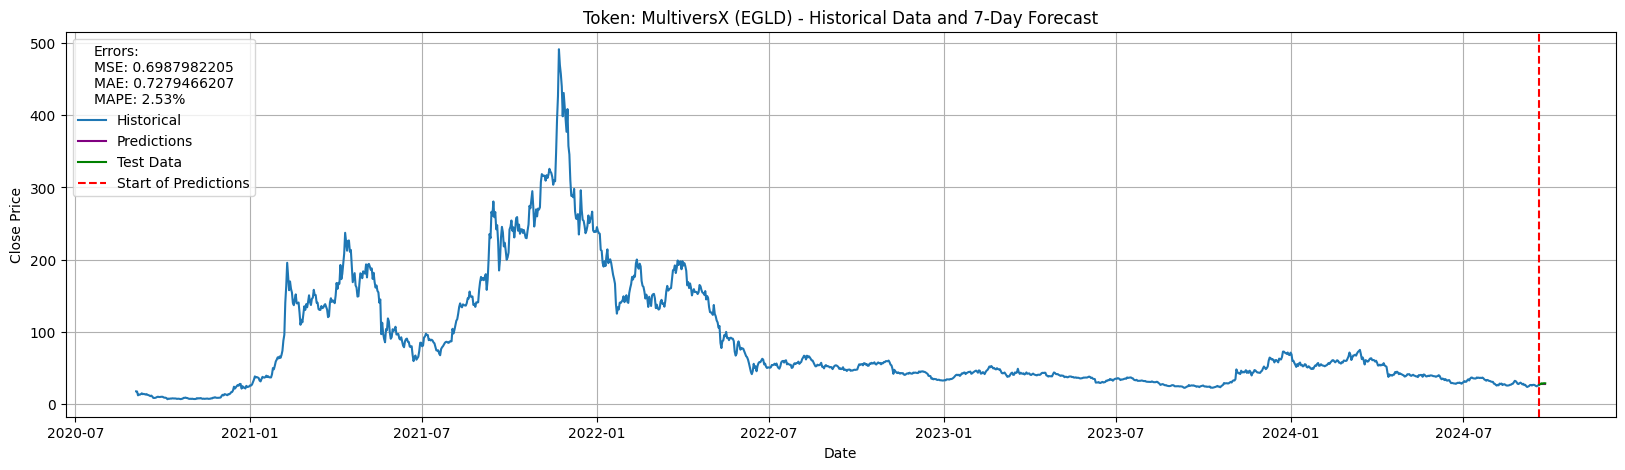

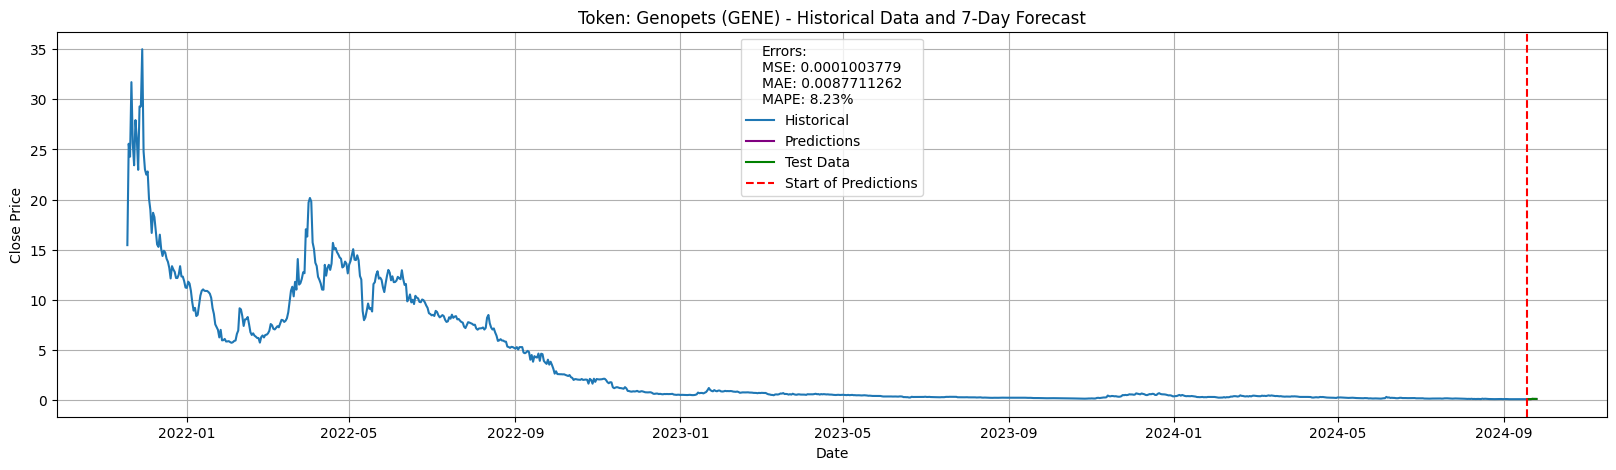

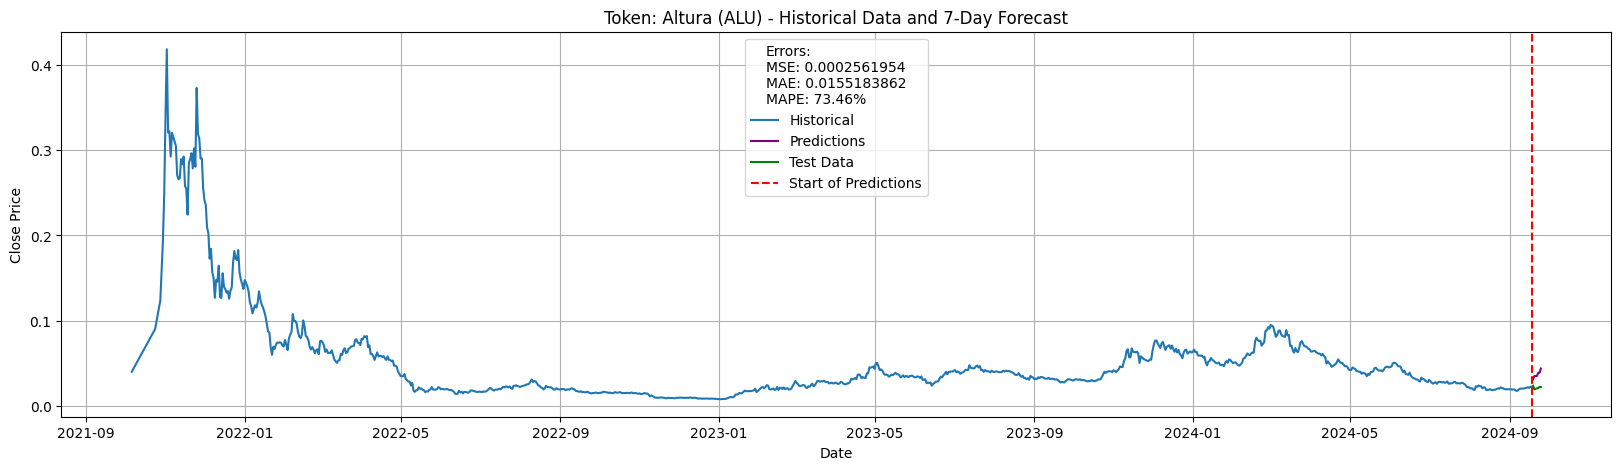

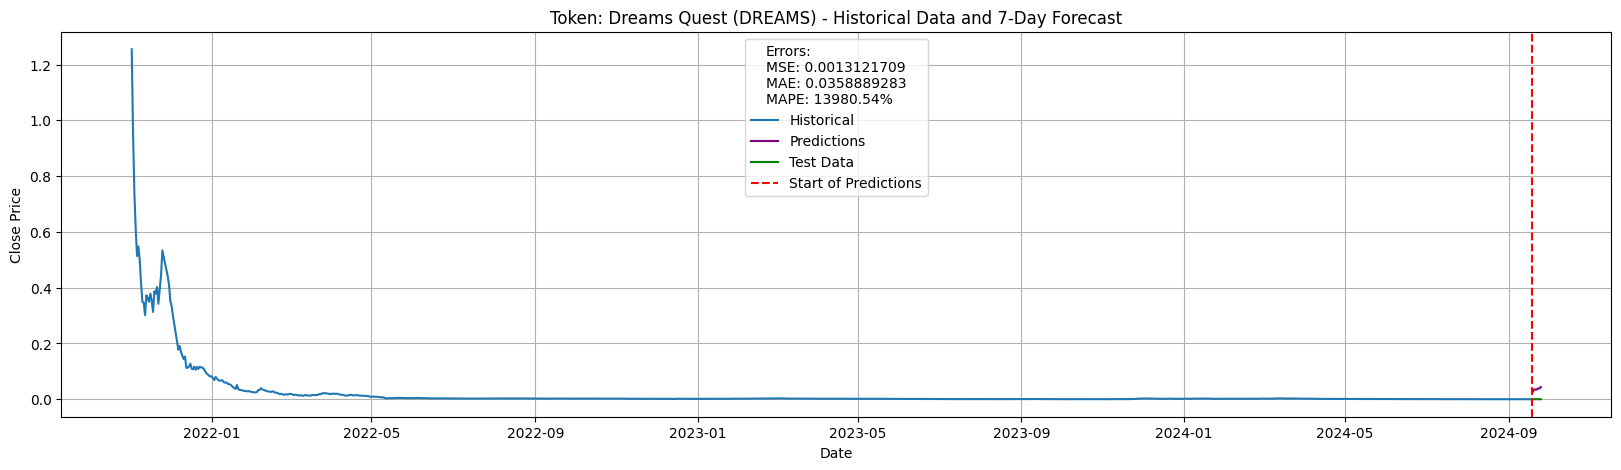

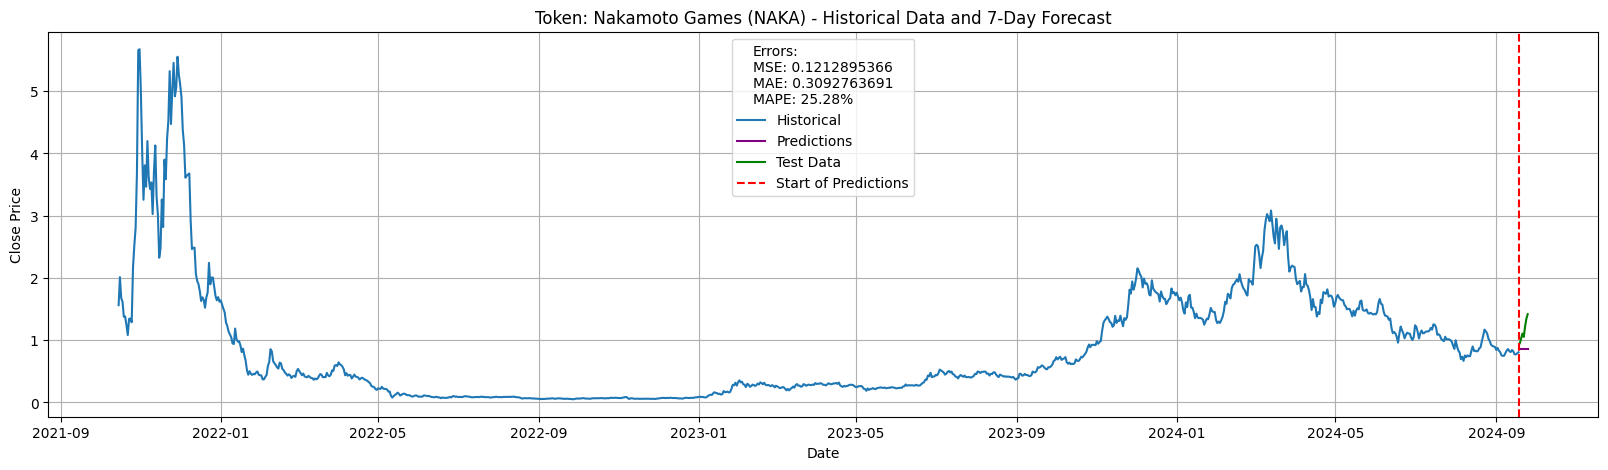

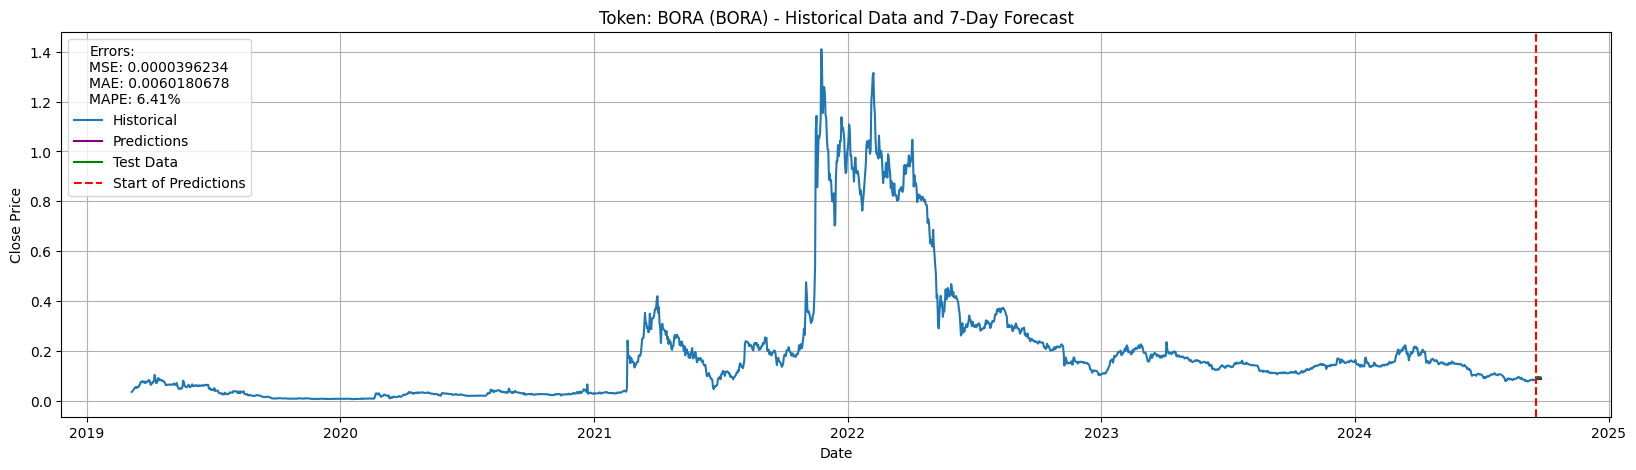

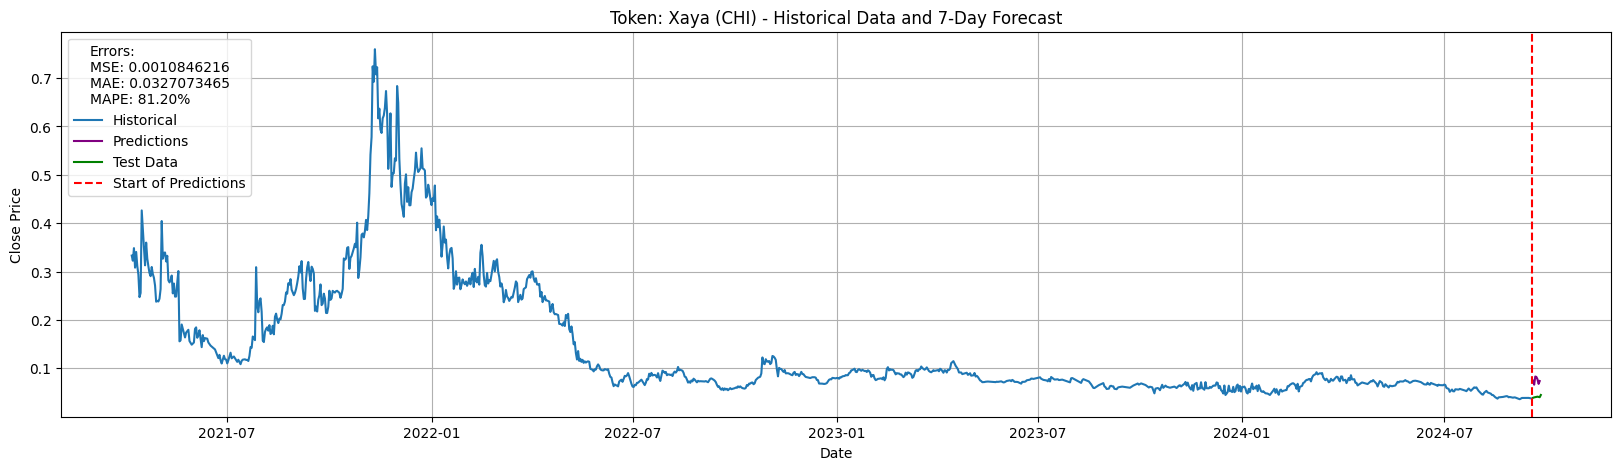

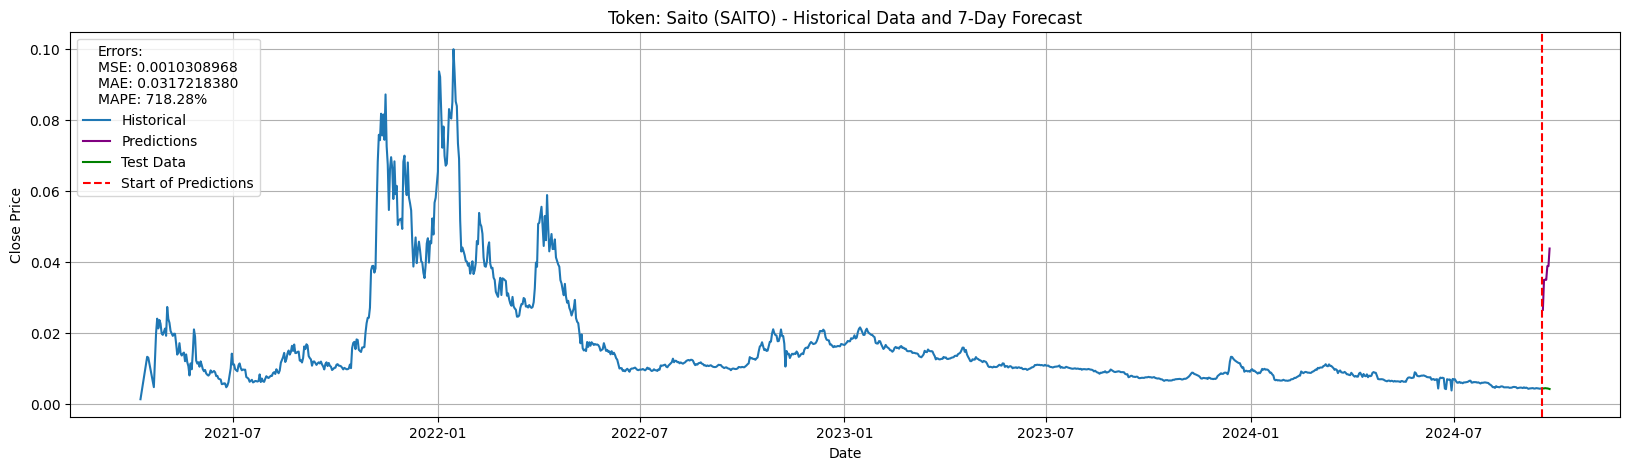

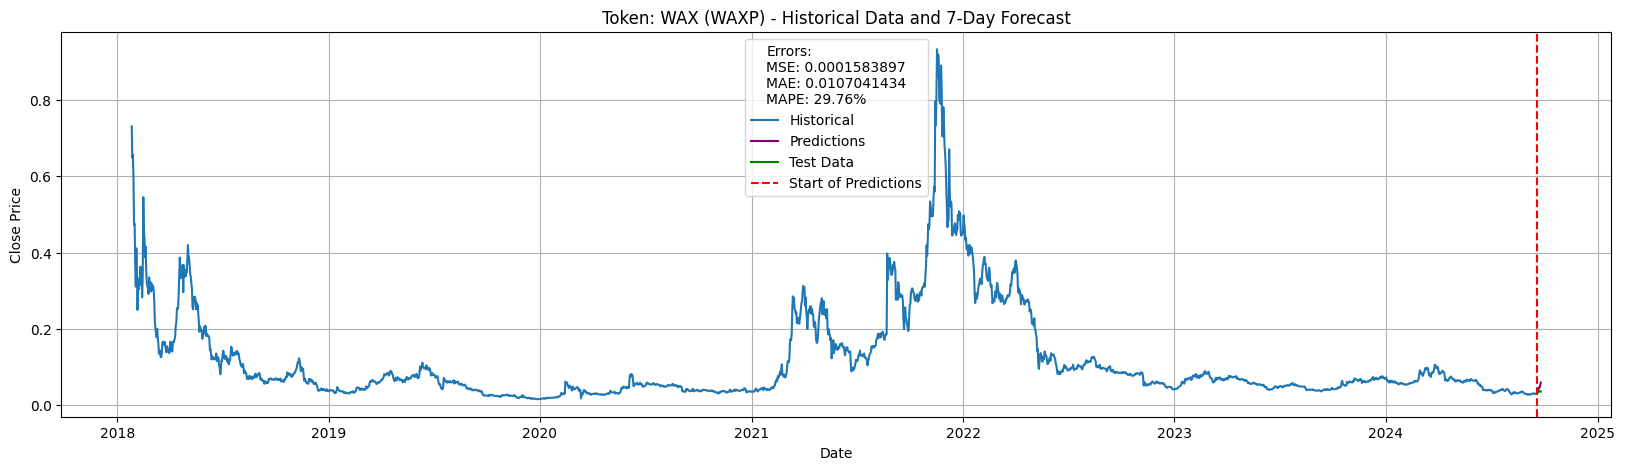

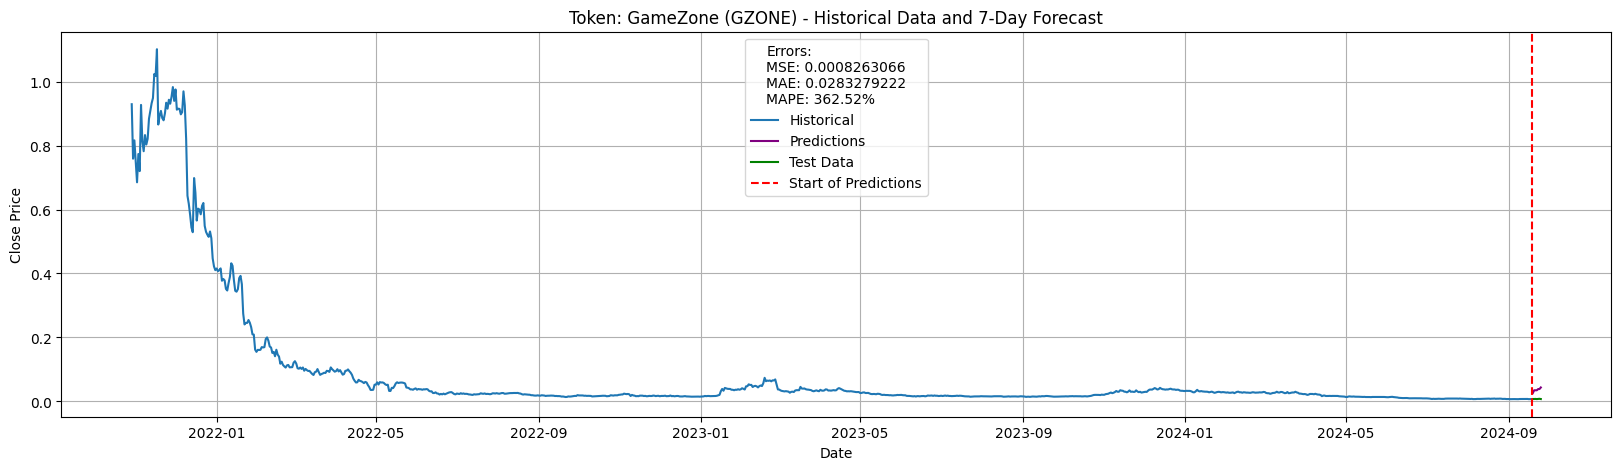

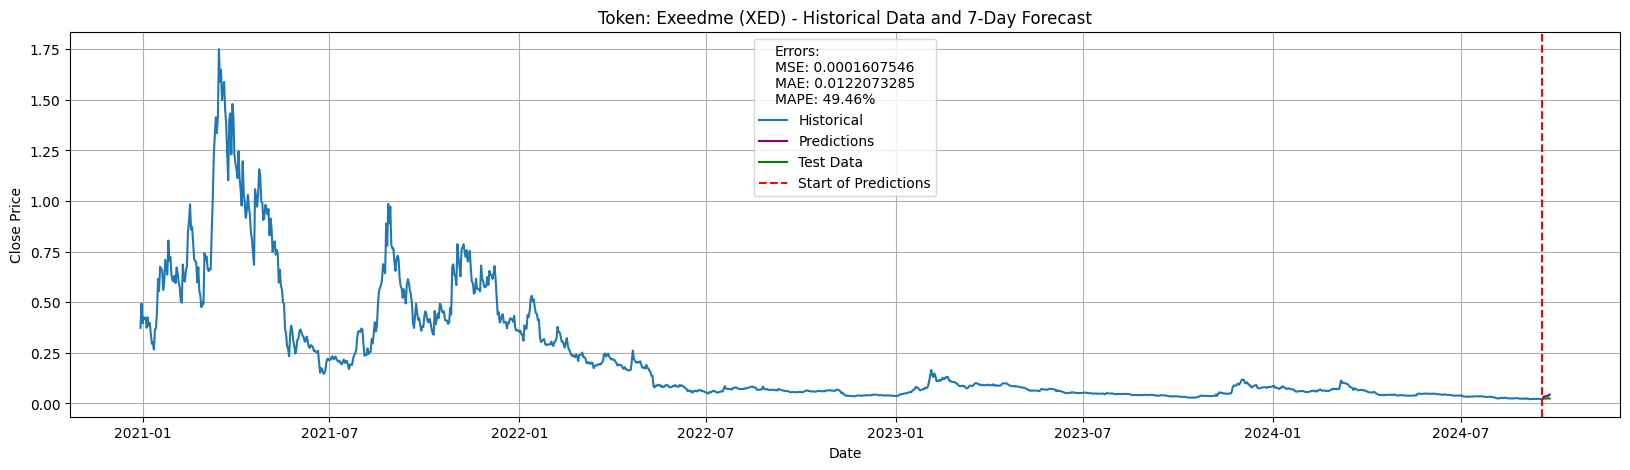

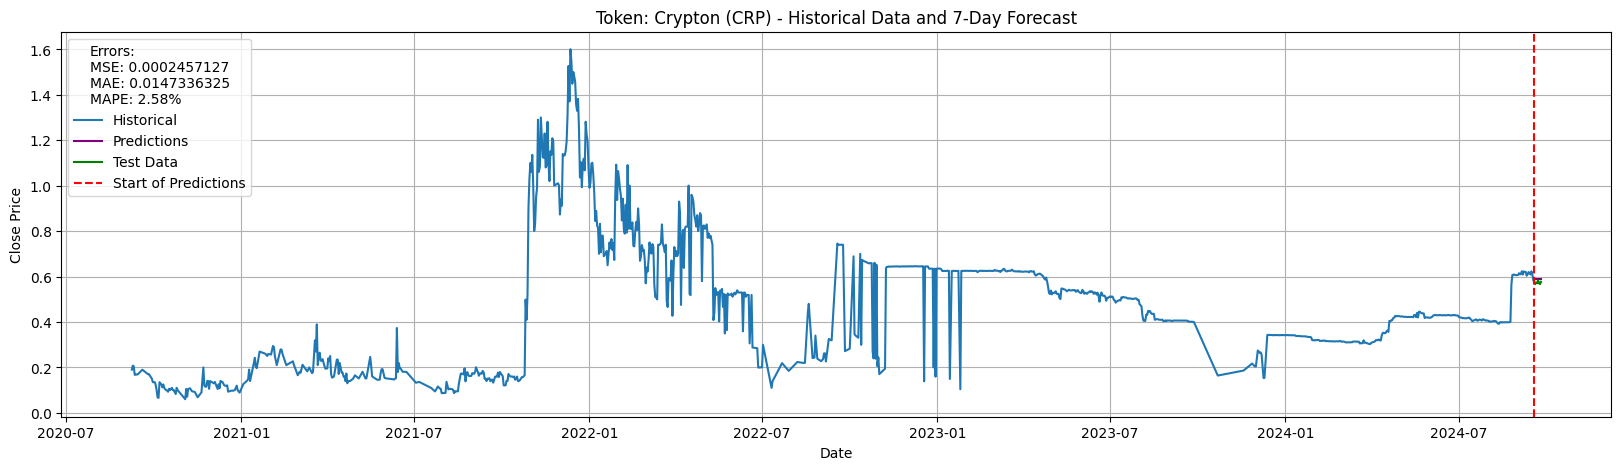

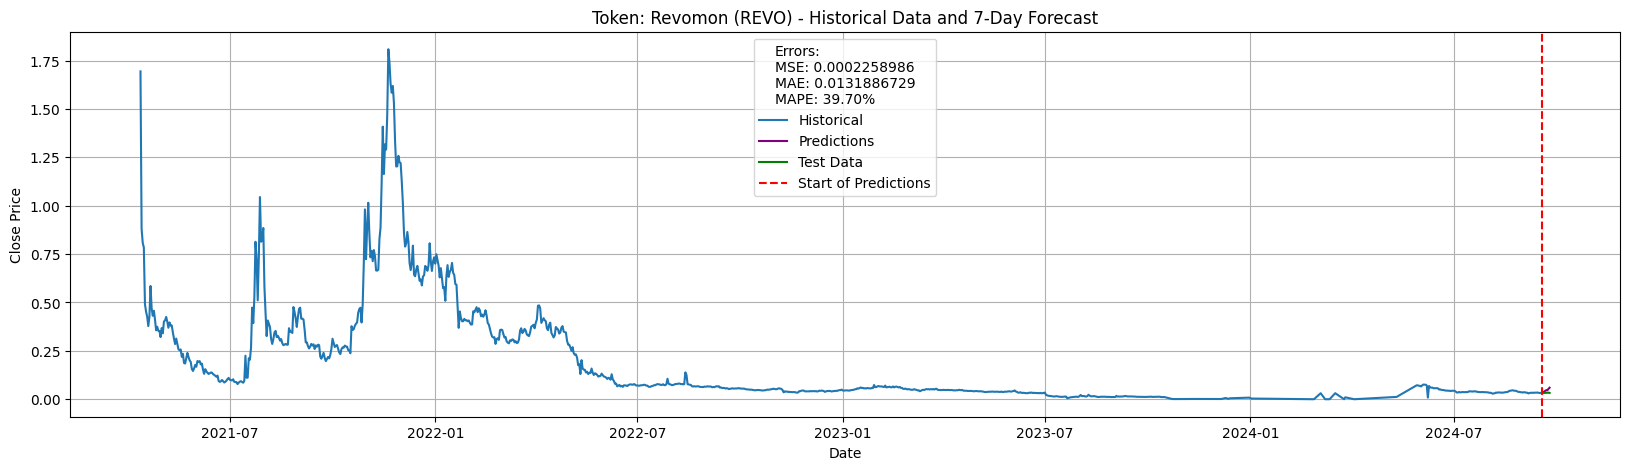

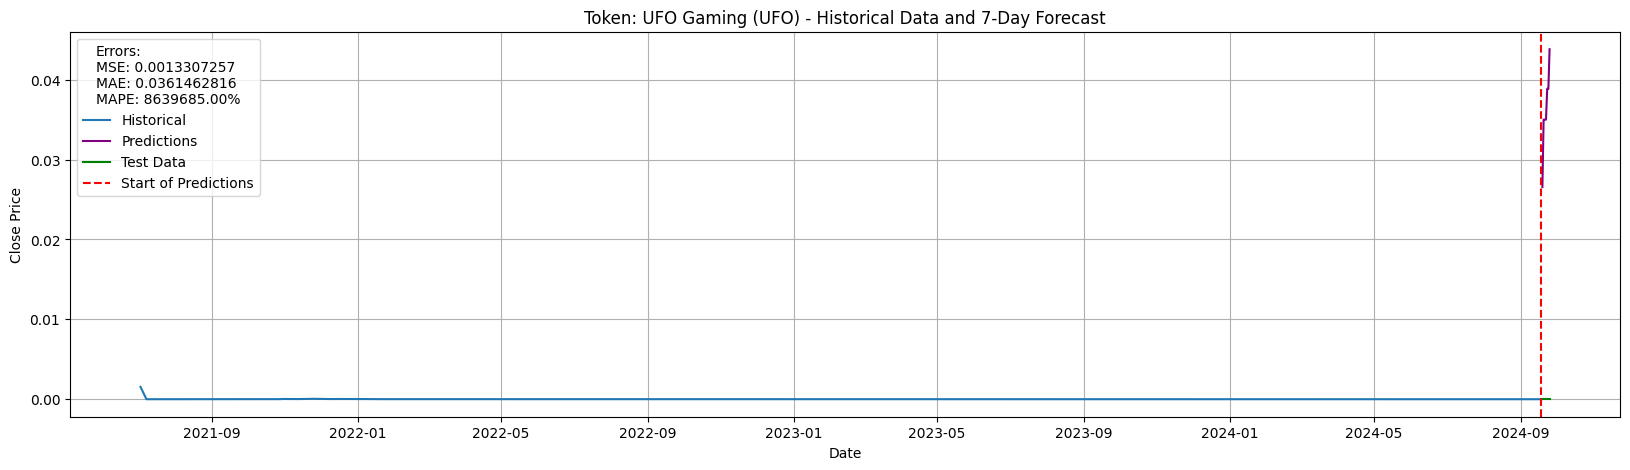

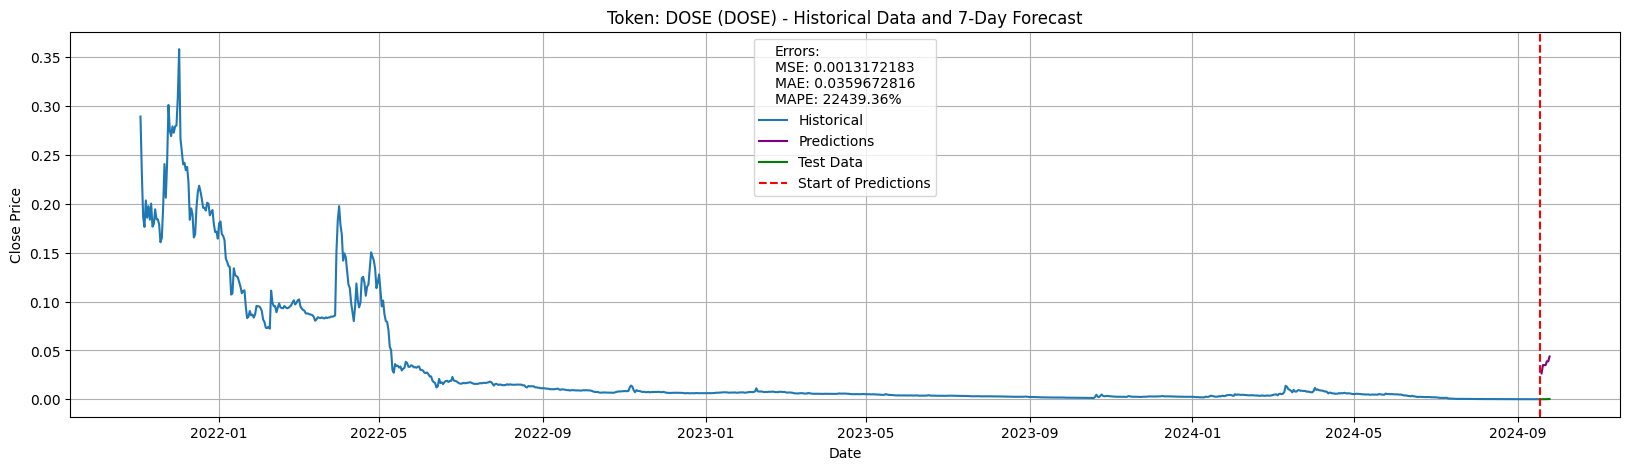

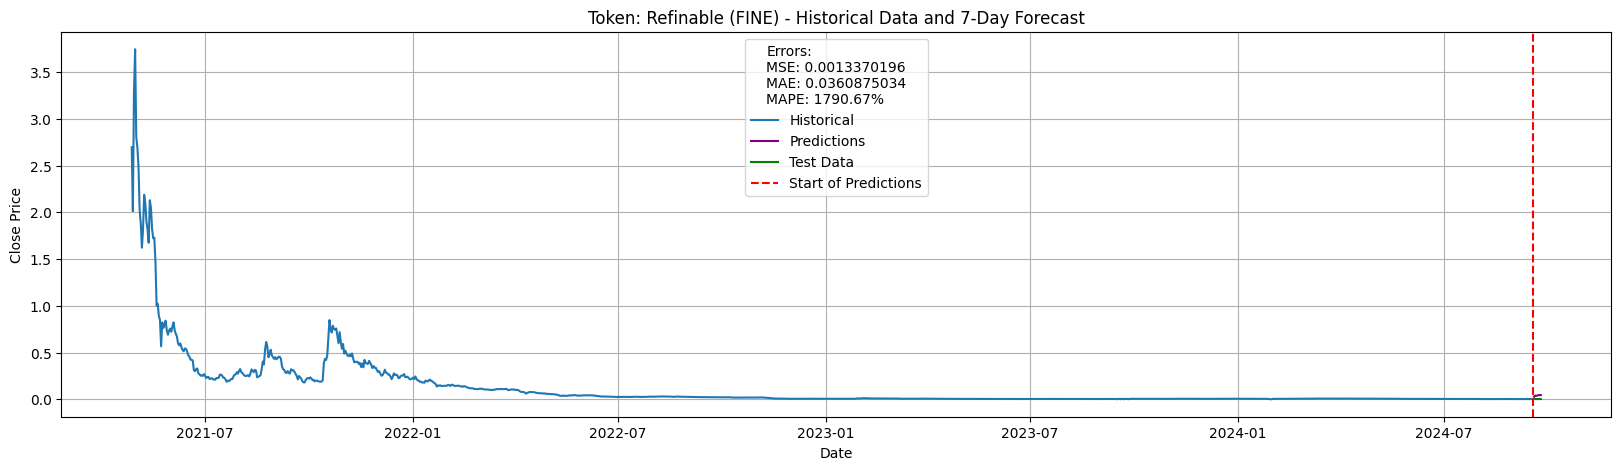

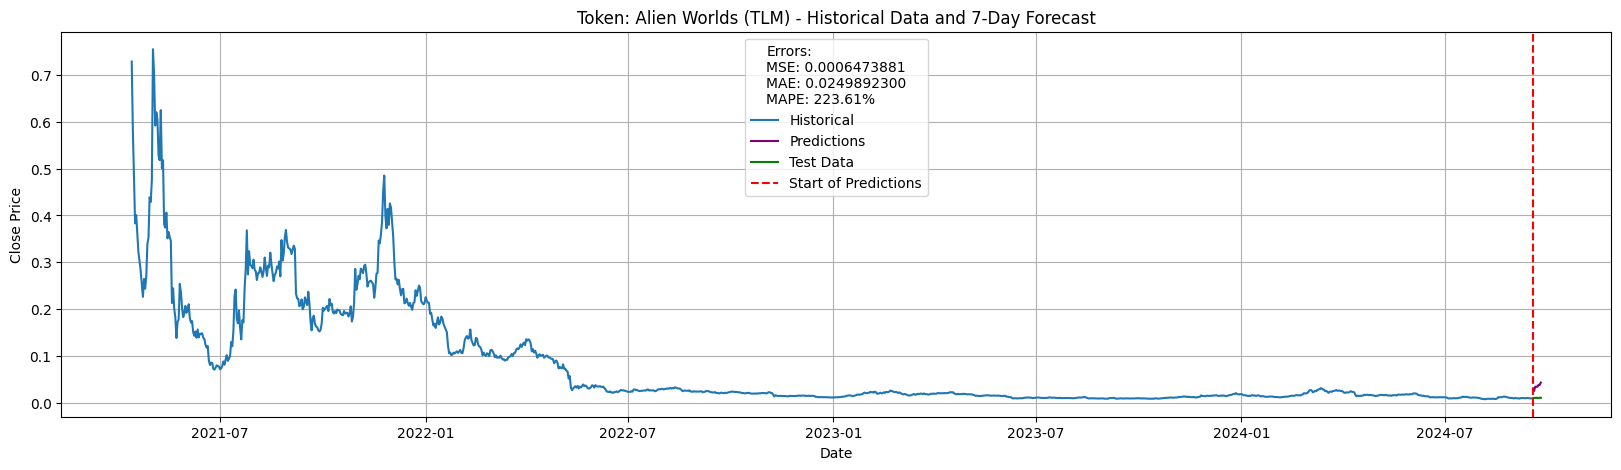

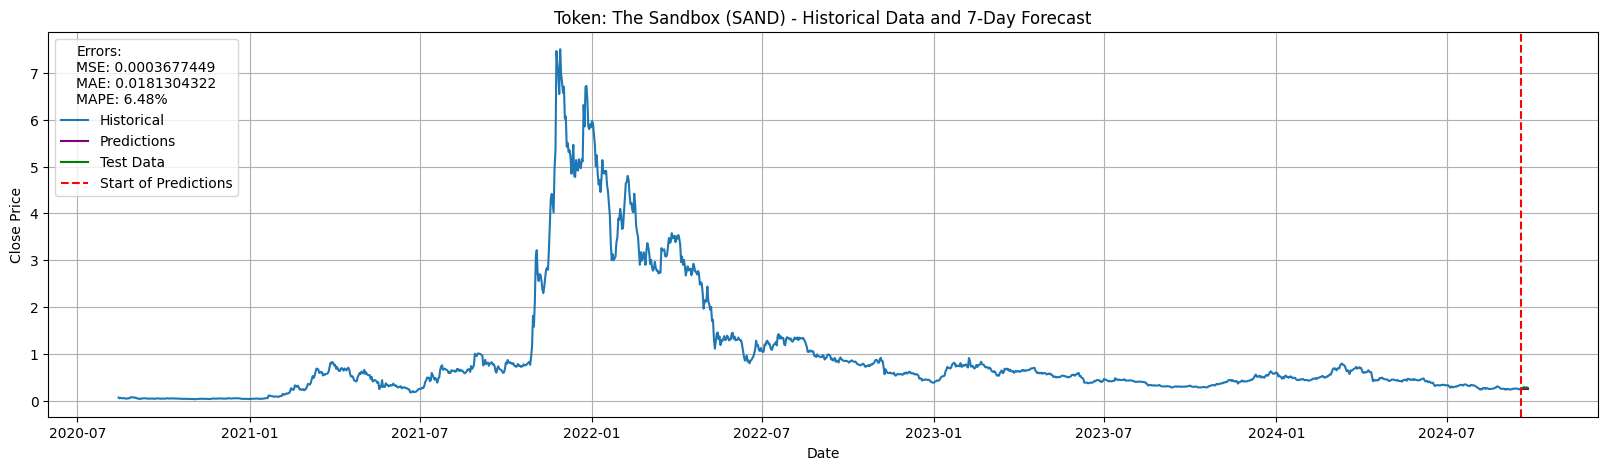

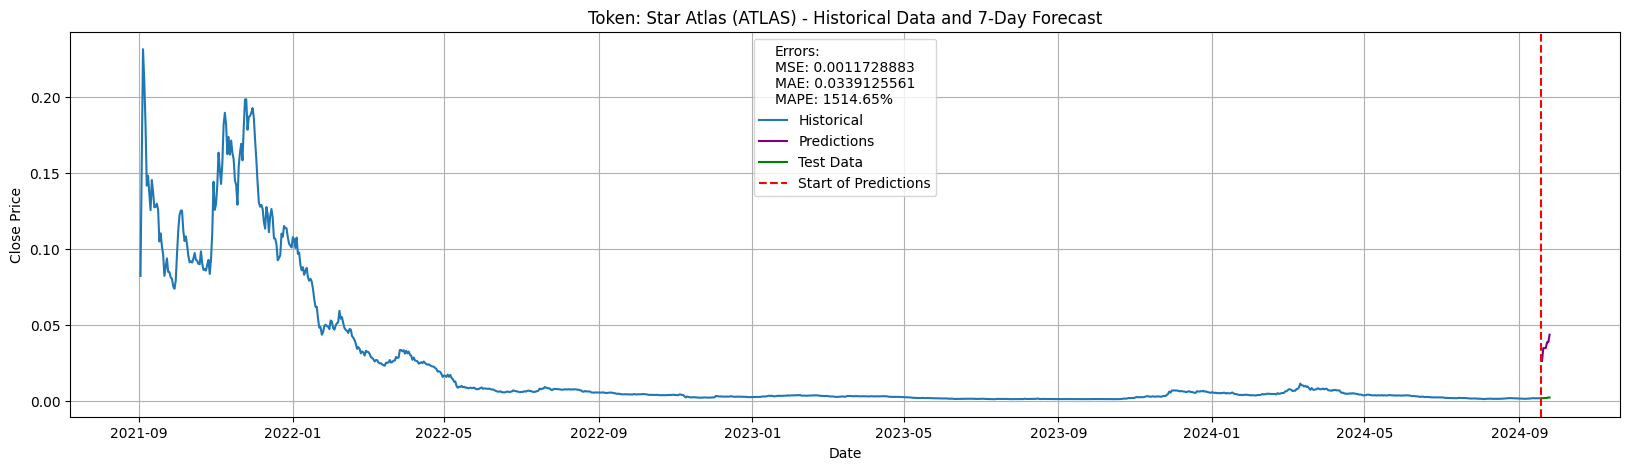

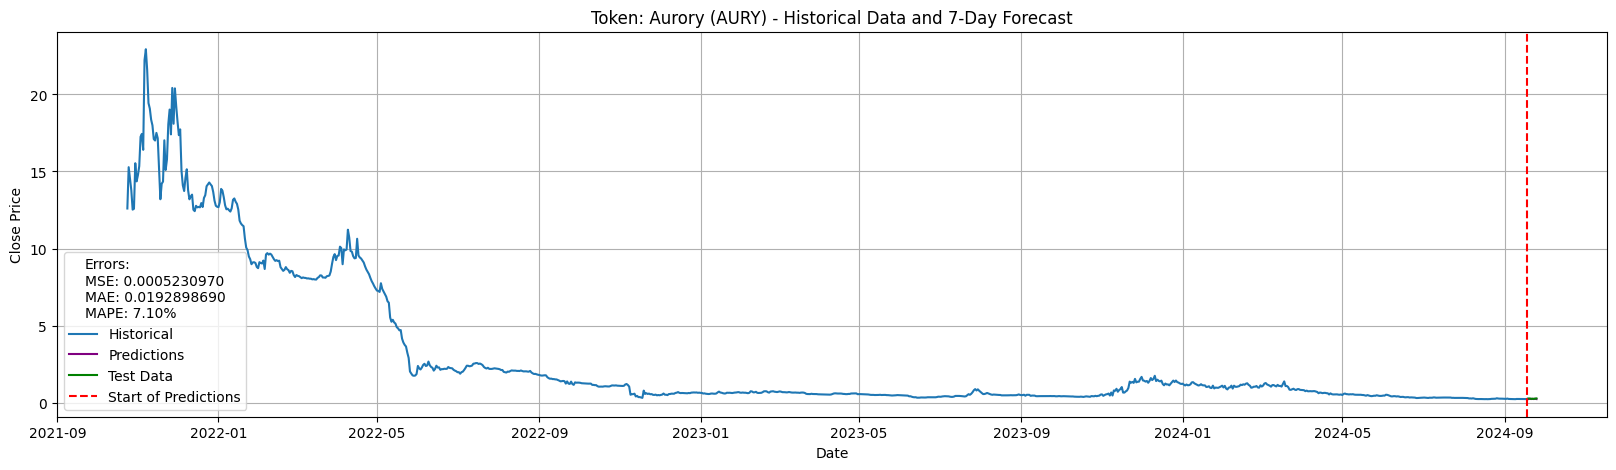

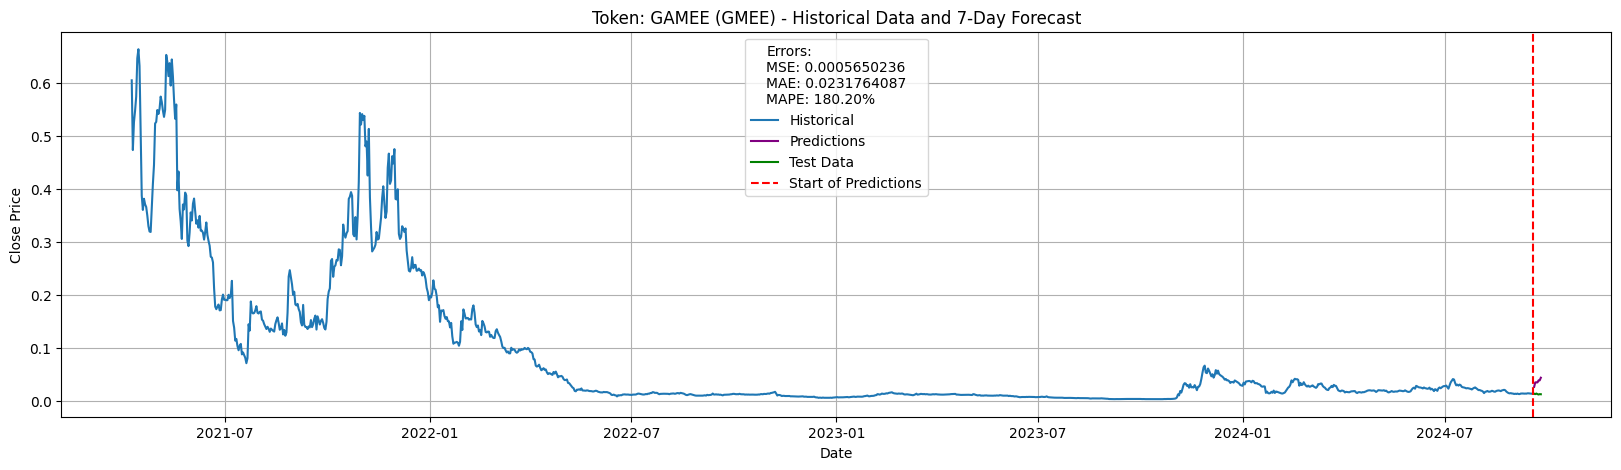

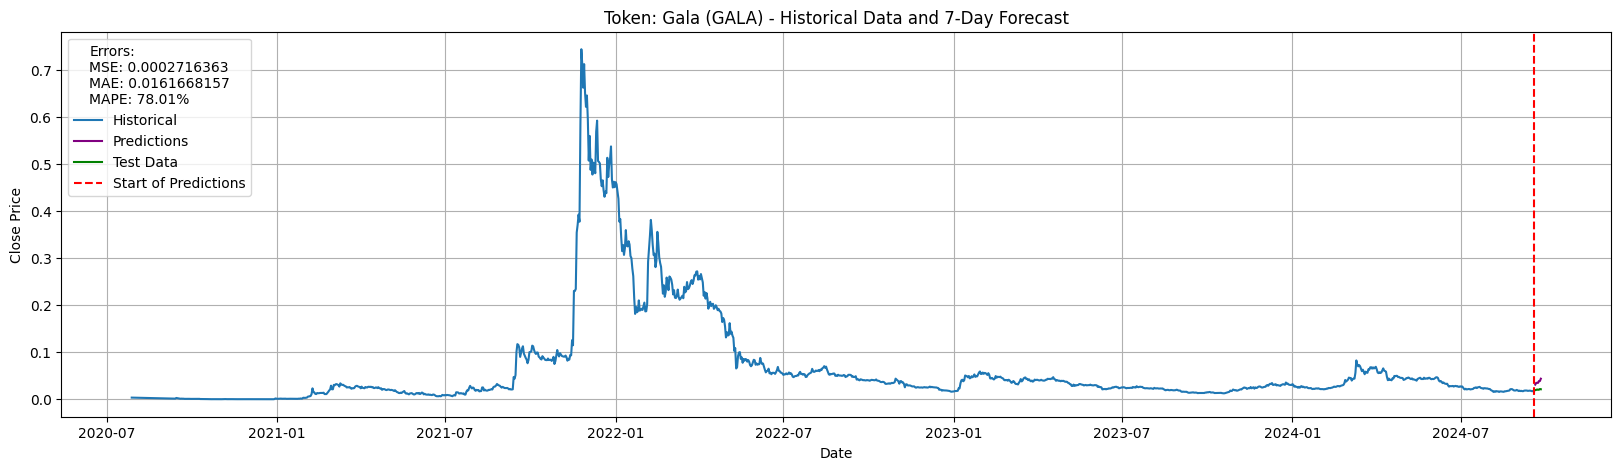

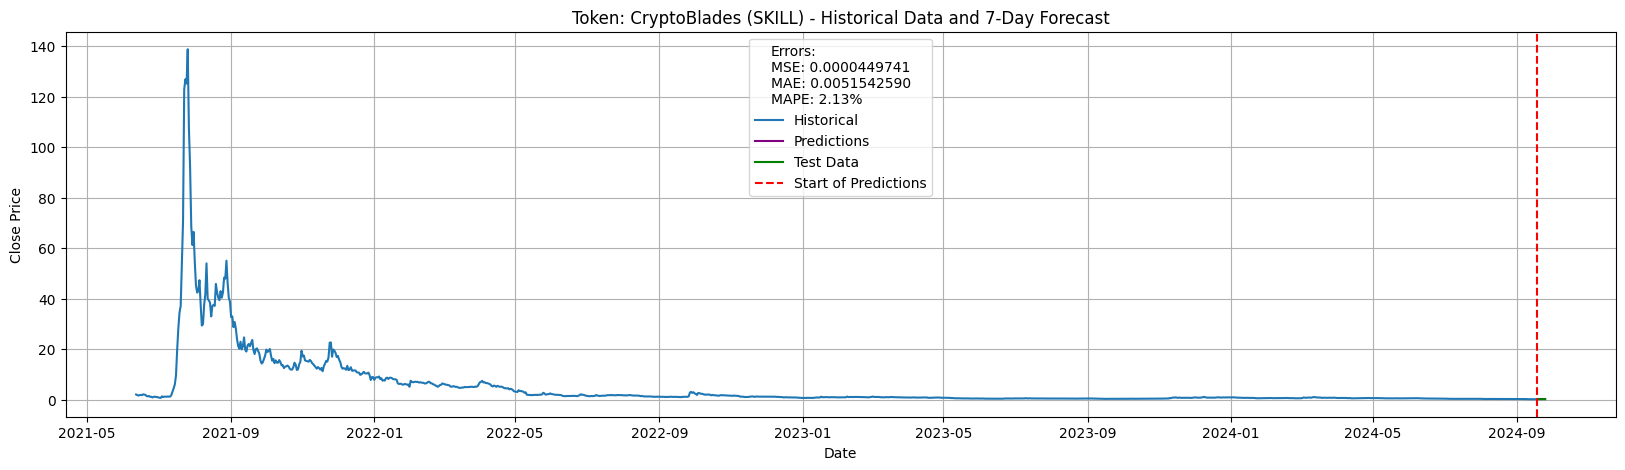

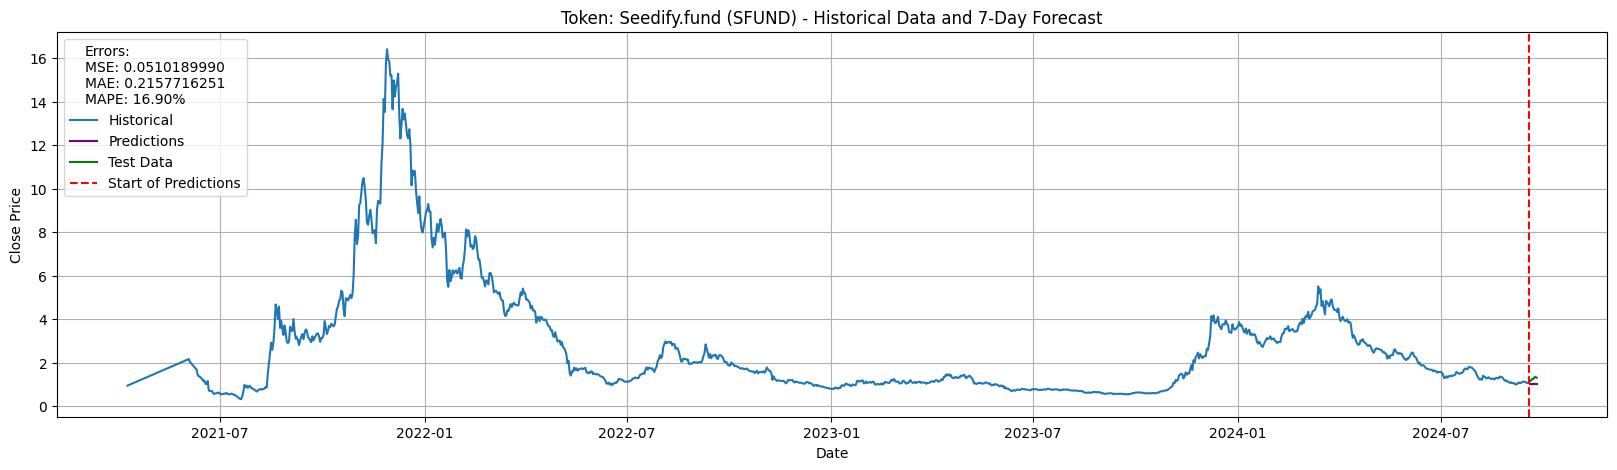

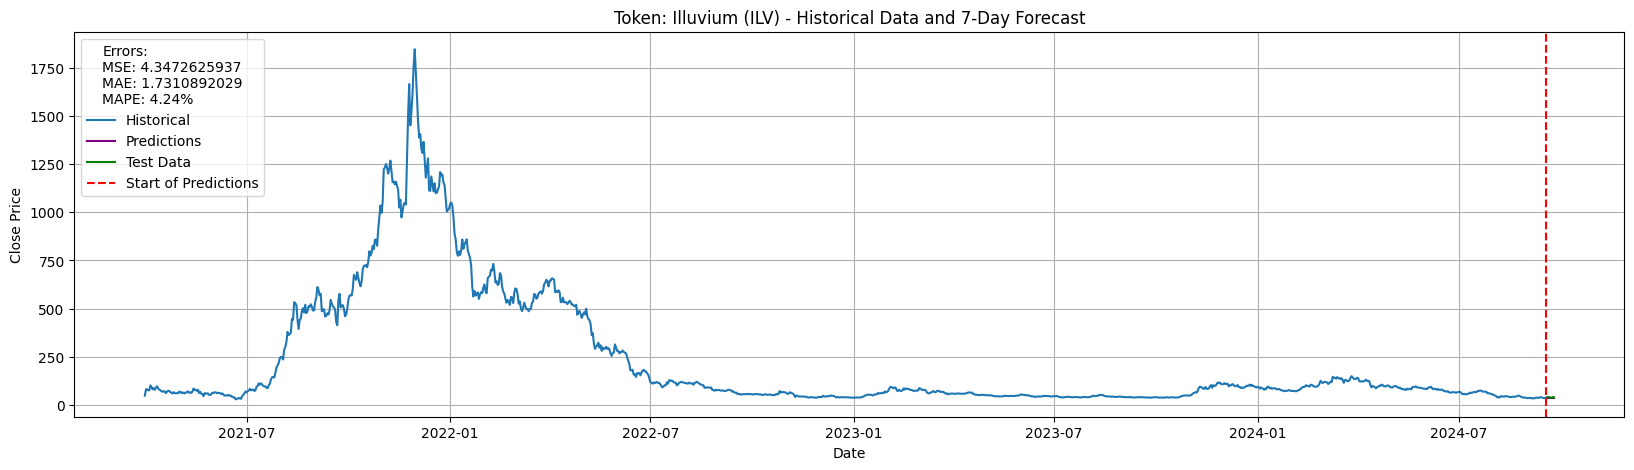

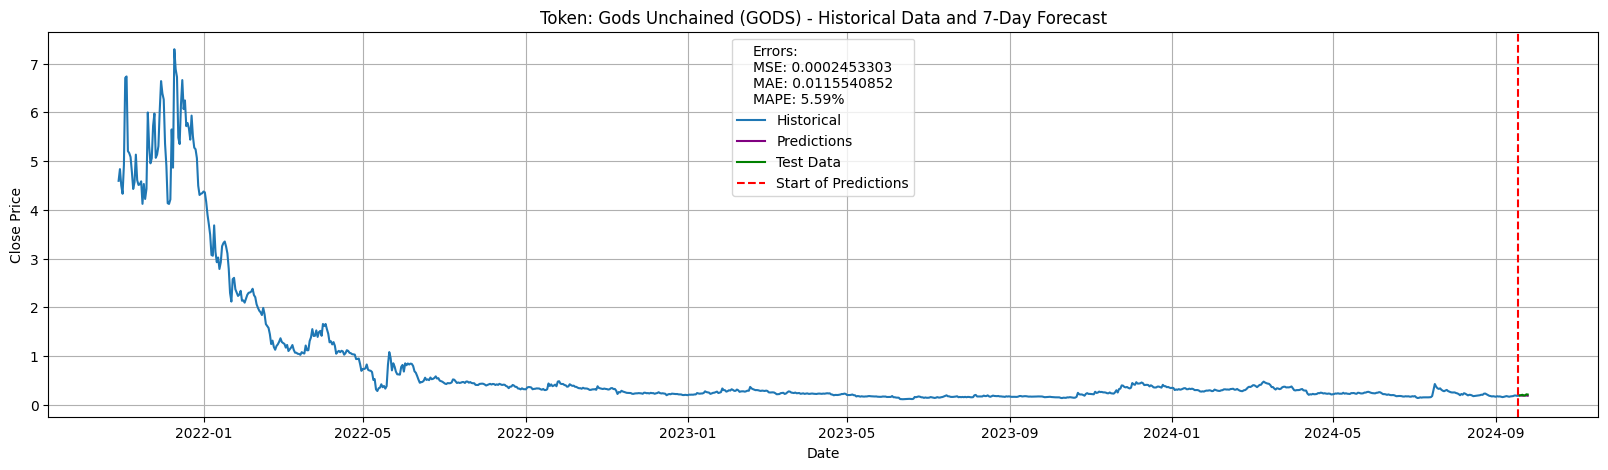

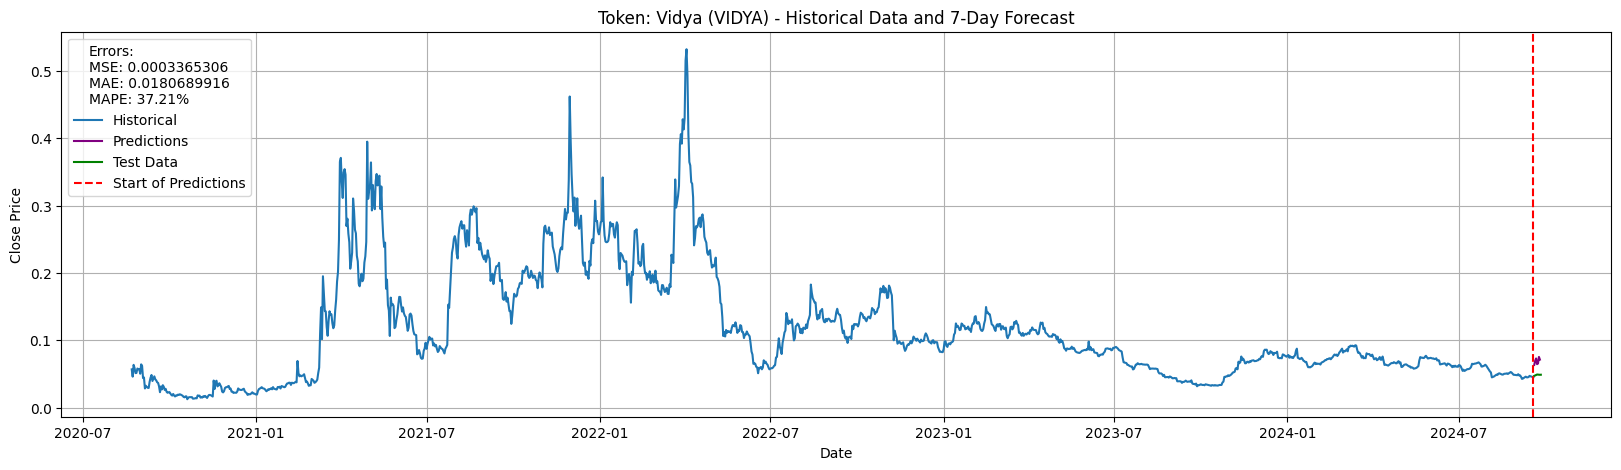

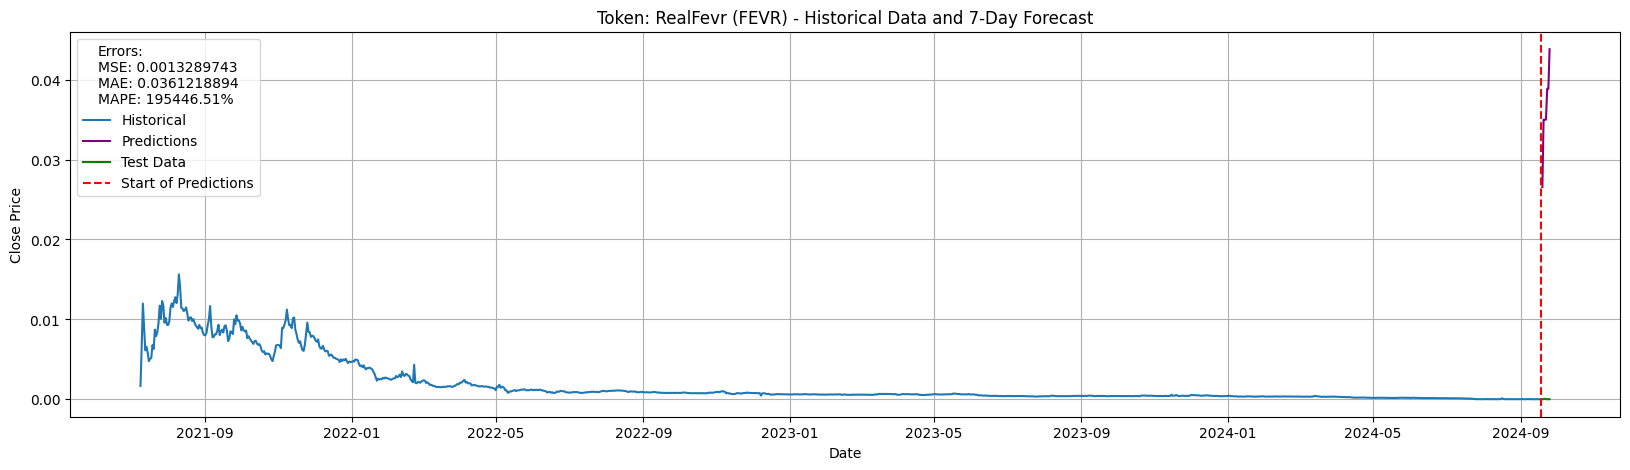

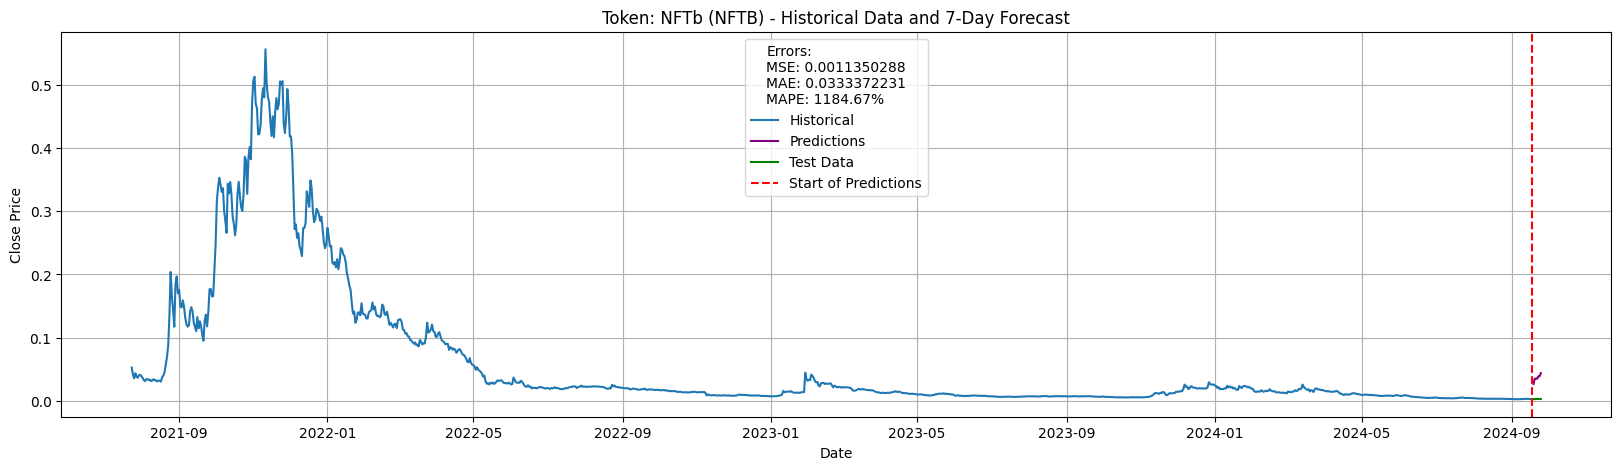

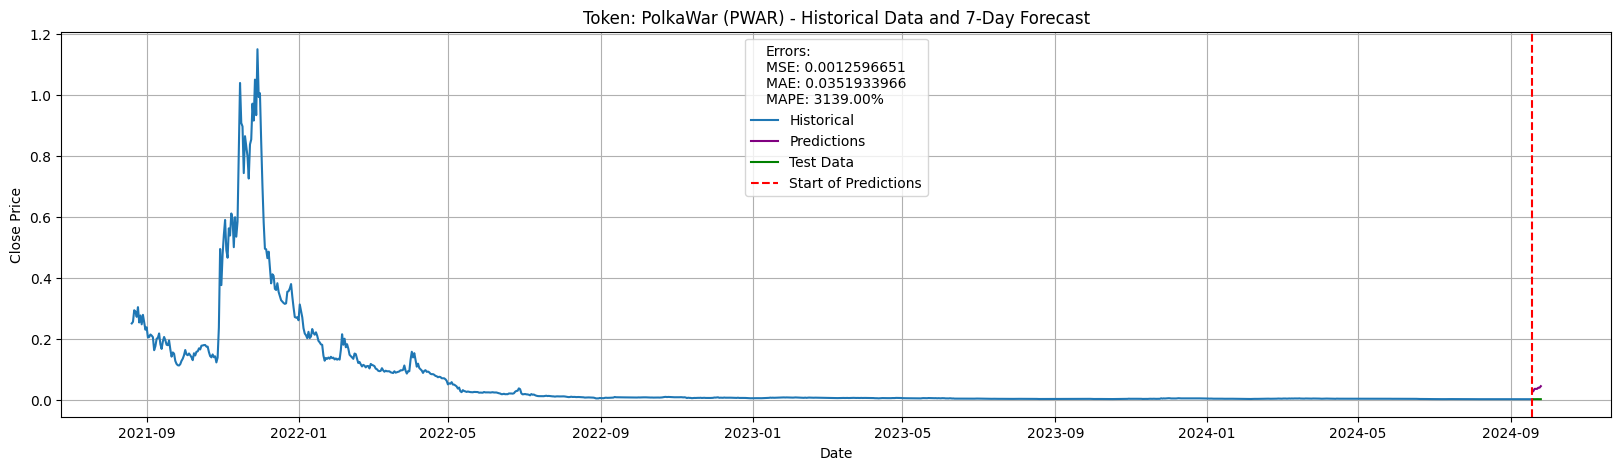

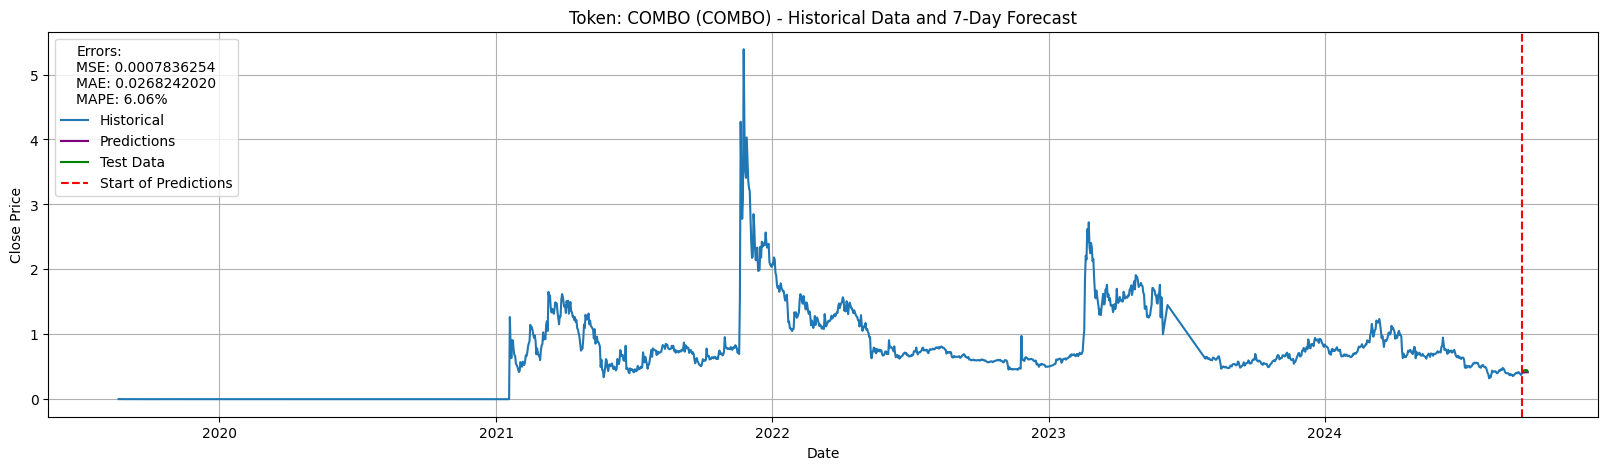

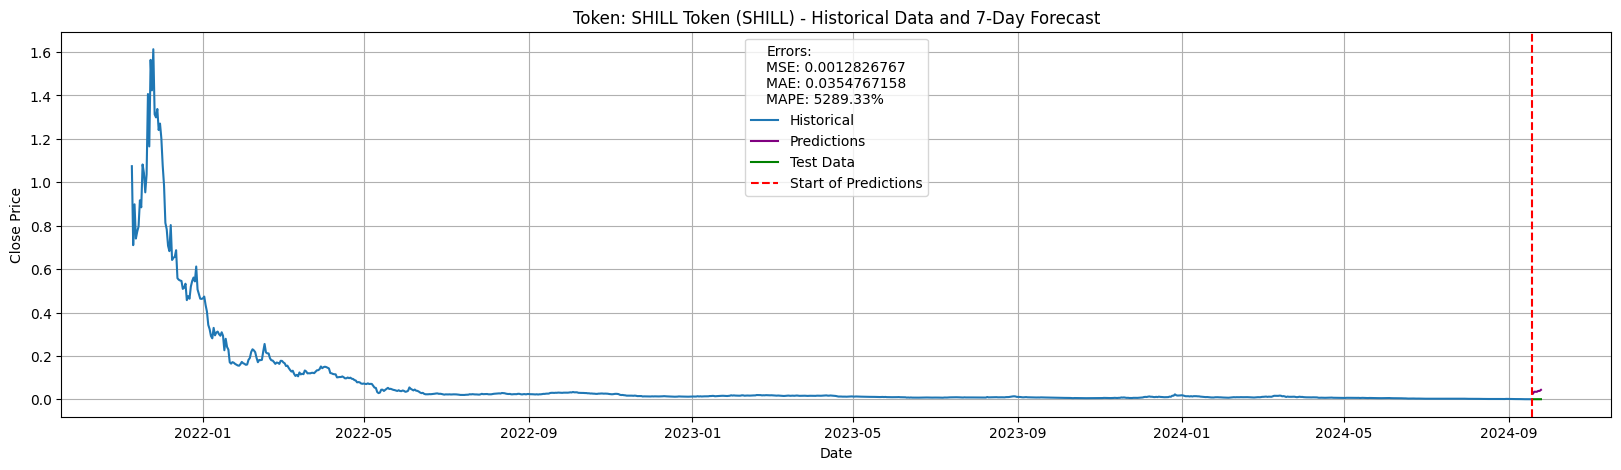

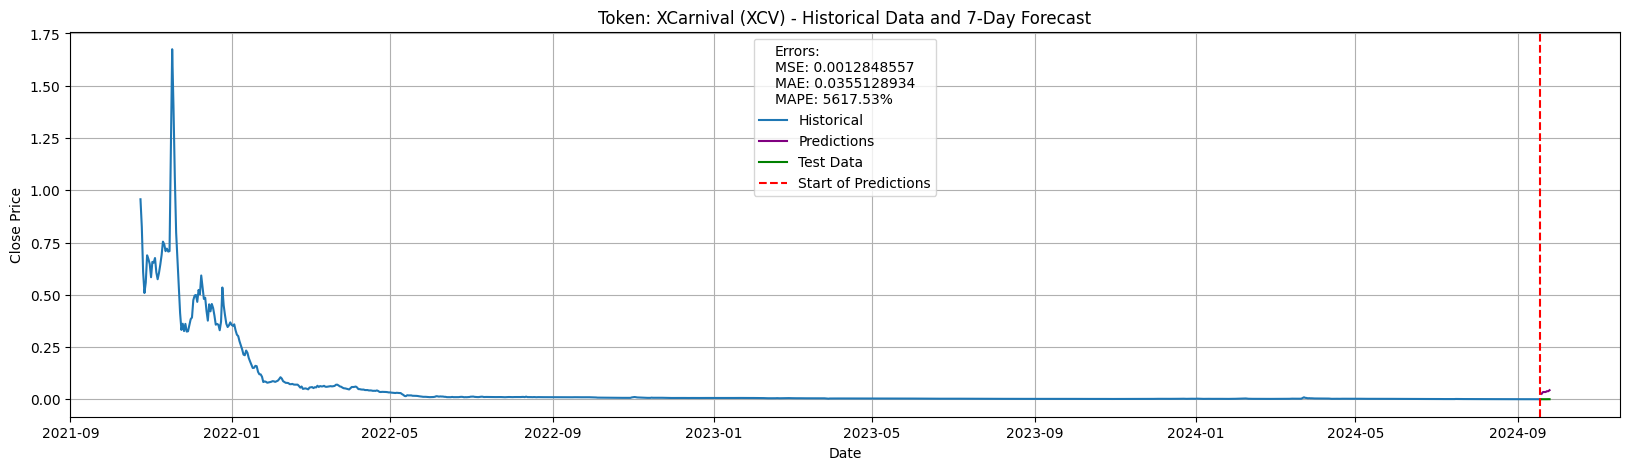

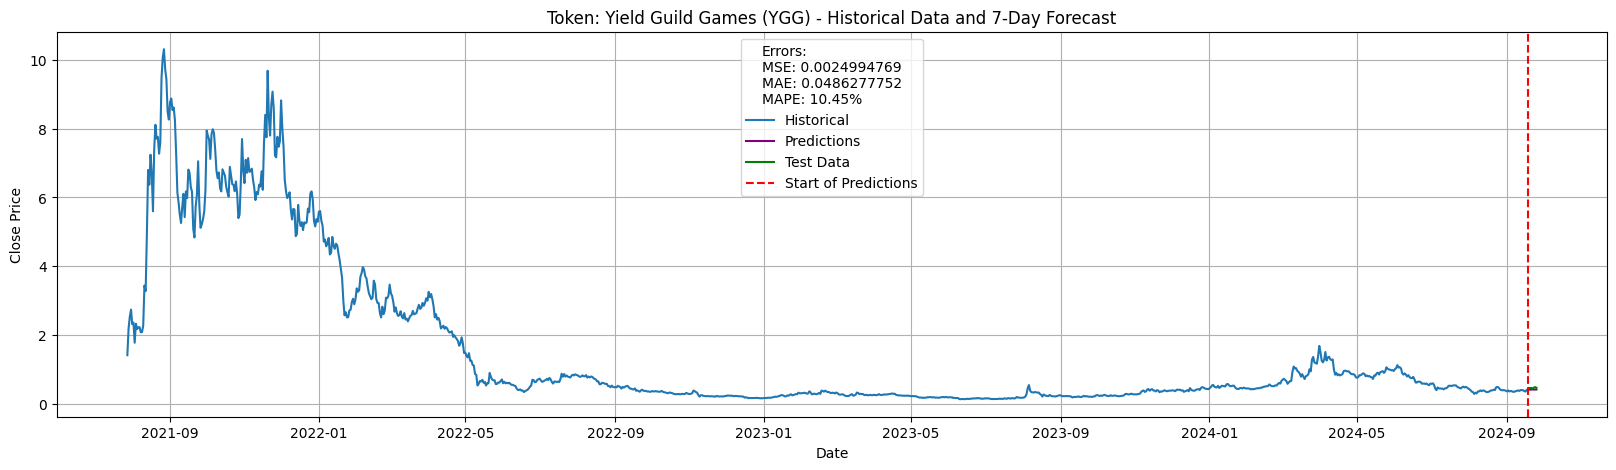

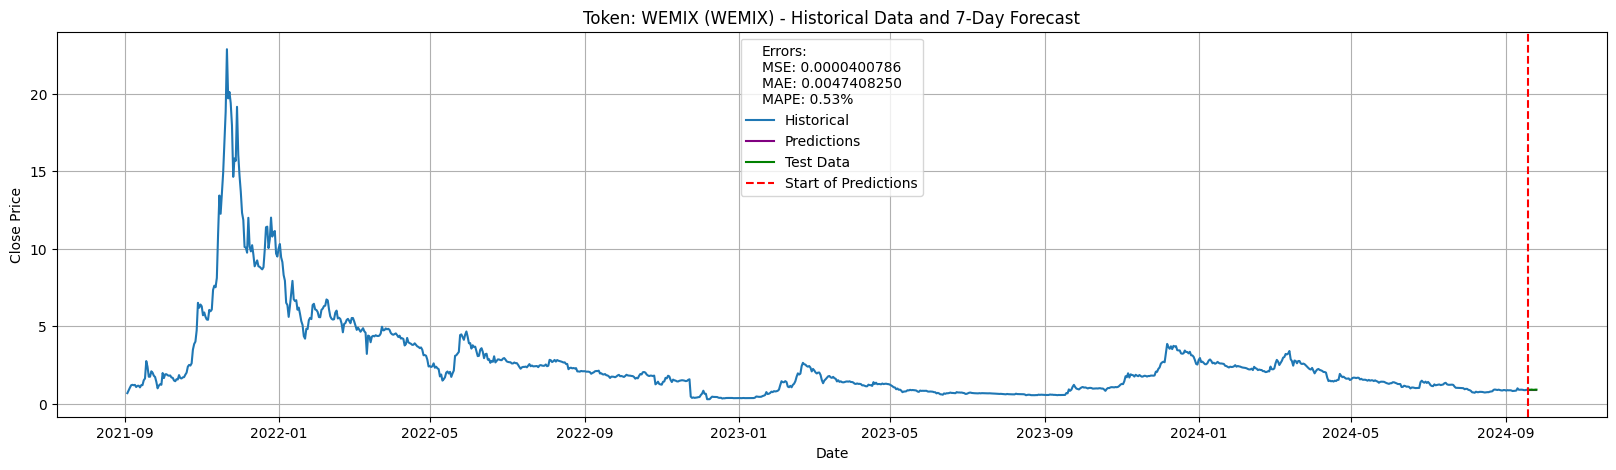

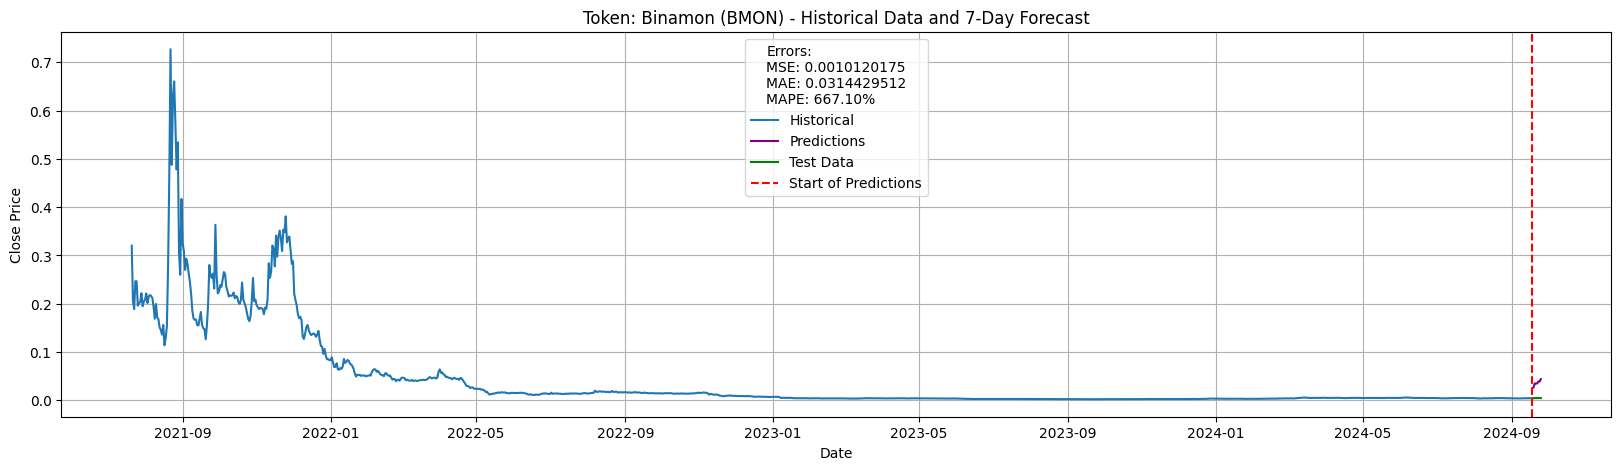

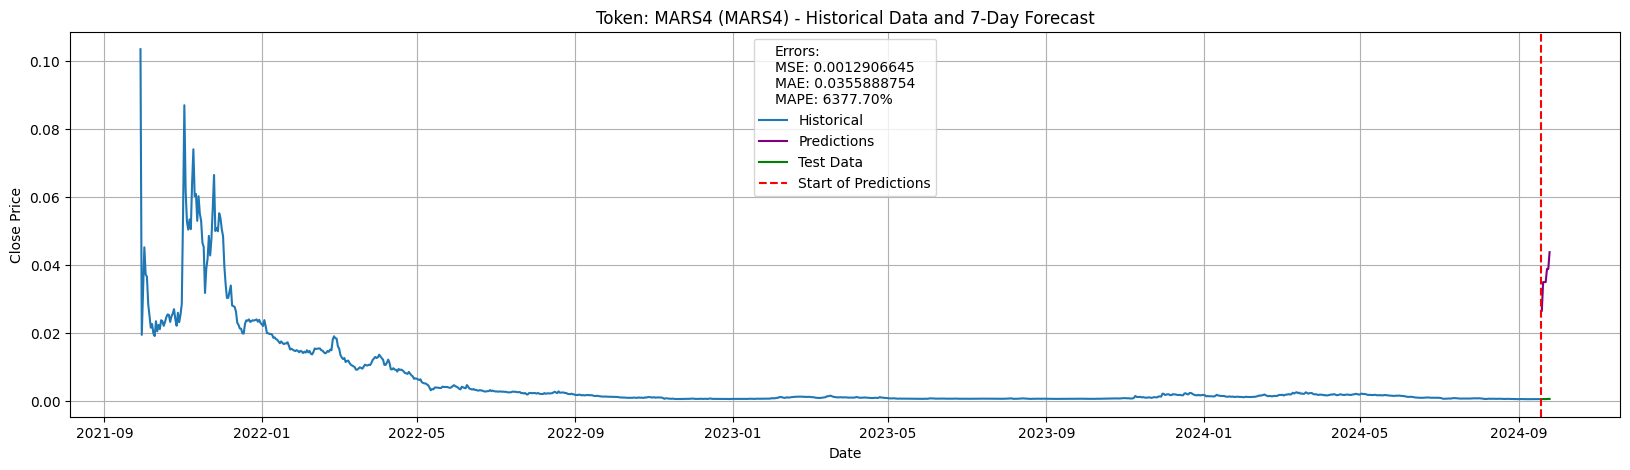

In [7]:
error_df = u.plot_predictions(train_data=og_train, predictions_x_days=og_pred, test_data=og_test, max_coins=0, last_data_points=-1)

In [8]:
error_df

Token ID       MSE       MAE          MAPE
0   06963e10-2042-41d3-9583-acb4135460dc  0.001096  0.032743  9.606377e+02
1   0844705f-10ed-42ca-b483-914b7d59e351  0.001343  0.029778  9.662919e+00
2   10e910bd-6f50-4085-bd78-fbbcde408d28  0.000013  0.003215  4.494826e+00
3   1ae14641-7365-4be1-9bb9-c86ab07715b3  0.003649  0.048735  4.939278e+00
4   2150225f-b2f2-4b59-bc68-001aa8ae4666  0.000158  0.011406  3.185523e+01
5   246715d6-065f-475e-8026-3e0a201c7e33  0.001291  0.035592  6.485158e+03
6   24e85250-c2a7-4158-8e7d-244818085463  0.000292  0.015379  3.624052e+01
7   30d41b9d-f8eb-4821-8a6e-9016bfd35023  0.004179  0.062647  3.316742e+03
8   39268841-e3d8-40b3-8c30-6d6d5bb19bf4  0.000017  0.002892  1.904148e+00
9   3a048f18-7aab-4abf-87bd-9f70572c5a9e  0.001105  0.032862  1.005258e+03
10  3bb77159-e905-41bf-9321-ca414622cc2b  0.001122  0.033124  1.097901e+03
11  3f548a16-866f-4e2c-b3e9-5df6d32d9083  0.000032  0.004066  4.282571e+00
12  40aa59cc-c529-4ac7-a8b9-9c20fd8acae5  0.014580  0.115378  5.293634e+00
13  42da9689-d86b-40b6-a637-ed56c564edc9  0.000494  0.021702  1.500762e+02
14  4315622d-ca20-4ac1-96ee-8667d8b81797  0.001331  0.036147  1.759017e+08
15  46f2989f-7eb3-49e4-a32f-5064d6f5b1dc  0.001329  0.036122  1.458033e+05
16  50d82ac0-c63a-4c7b-9f7b-d6113ae46617  0.001302  0.035746  8.952341e+03
17  52b9da0d-1cb2-4de2-bcf2-1b43cbb584c6  0.043336  0.177943  3.487951e+00
18  594c4880-8132-45d1-9c86-68a8b0b18514  0.000164  0.007600  7.944368e+00
19  5df45553-ca41-4567-afe2-8077d54992cc  0.000759  0.027086  3.139984e+02
20  666b535c-530a-4f32-a7aa-21905cb5b9b7  0.000912  0.029714  1.090701e+01
21  67045600-171b-4417-b9e3-db2c5a950dc9  0.698798  0.727947  2.534679e+00
22  6a25b7d5-8193-403d-b2b3-b72fd98c55fb  0.000100  0.008771  8.230394e+00
23  6a998be7-42e5-4047-b55d-99e058bf2248  0.000256  0.015518  7.345678e+01
24  6e87c632-4d4b-4c8f-aa8d-edb52a87125c  0.001312  0.035889  1.398054e+04
25  6f3d4d83-badc-4d5a-b487-a70cea172cab  0.121290  0.309276  2.528399e+01
26  70ffc67f-2d85-4162-8696-023dbc5f3d13  0.000040  0.006018  6.414464e+00
27  7234c1e3-87f4-4a15-b023-daf350f17429  0.001085  0.032707  8.119524e+01
28  74a71d75-c6fb-4d73-97ad-7f82ff56aeba  0.001031  0.031722  7.182847e+02
29  7a532850-9ec9-4780-94ad-d2759dc1c5cf  0.000158  0.010704  2.975831e+01
30  81cb66e8-37b1-4f24-a597-04ee4a0456cc  0.000826  0.028328  3.625198e+02
31  83d9ca82-15f9-46ca-a80f-74df4f7a055b  0.000161  0.012207  4.945782e+01
32  84a7fc09-daeb-470b-be15-575a493a4069  0.000246  0.014734  2.581564e+00
33  8b4ba1e4-6a45-4738-9695-cbe7388760cf  0.000226  0.013189  3.969935e+01
34  8c28c829-ac6b-45e8-9cc0-47441be493e1  0.001331  0.036146  8.639685e+06
35  8de8d193-45b7-4a95-81ff-4a3c1114a102  0.001317  0.035967  2.243936e+04
36  979cf48d-4724-4647-9c6b-1f3d6e23bfca  0.001337  0.036088  1.790671e+03
37  98482dd5-6663-4a5f-b93a-b3ac05502123  0.000647  0.024989  2.236134e+02
38  9e79e939-dc11-445e-91b9-1e0ec35180fd  0.000368  0.018130  6.484031e+00
39  a252b851-675b-4244-a655-3a773ec53584  0.001173  0.033913  1.514649e+03
40  a3a65b10-ea76-4cfe-a22a-22bb8455aa99  0.000523  0.019290  7.102142e+00
41  a8ef4bc2-b81f-408b-99a8-faef416e1234  0.000565  0.023176  1.802031e+02
42  a98165fb-f93b-4a46-8ac3-ea61f14ebe59  0.000272  0.016167  7.801068e+01
43  abb61f82-3489-4368-bf0b-407a96a42a49  0.000045  0.005154  2.126774e+00
44  adb1789e-2062-44eb-a285-9235e949bb55  0.051019  0.215772  1.689756e+01
45  b189d76c-98a1-4b07-868c-eb2460b9f3dc  4.347263  1.731089  4.235250e+00
46  b3eeb034-1d5b-4e73-9218-c4cf61d4423d  0.000245  0.011554  5.594280e+00
47  bce4e0be-b5c2-4f75-aa27-9c2631418558  0.000337  0.018069  3.721307e+01
48  c1b6fdae-1b30-462b-b47d-3f14e212e826  0.001329  0.036122  1.954465e+05
49  c1d1a22d-6776-4dd4-bb17-69965948c642  0.001135  0.033337  1.184670e+03
50  c2278b42-2ae4-4c4e-9aa8-ea7c6123b0a7  0.001260  0.035193  3.138995e+03
51  c5062f88-c5a4-4d4b-b313-8e9682150d46  0.000784  0.026824  6.059053e+00
52  def04c24-d3a3-4b80-8eb1-98f9a91c80c9  0.001283  0.035

In [9]:
error_df.describe()

MSE        MAE          MAPE
count  58.000000  58.000000  5.800000e+01
mean    0.091765   0.079229  3.189122e+06
std     0.576104   0.243951  2.310397e+07
min     0.000013   0.002892  5.278986e-01
25%     0.000260   0.015414  6.638558e+00
50%     0.001058   0.031582  6.145730e+01
75%     0.001326   0.035948  1.432154e+03
max     4.347263   1.731089  1.759017e+08

In [10]:
# error_df['MAPE'] is in fact a percentage, could you display the values with the %
error_df['MAPE'] = error_df['MAPE'].apply(lambda x: f"{x:.2f}%")

In [11]:
error_df

Token ID       MSE       MAE           MAPE
0   06963e10-2042-41d3-9583-acb4135460dc  0.001096  0.032743        960.64%
1   0844705f-10ed-42ca-b483-914b7d59e351  0.001343  0.029778          9.66%
2   10e910bd-6f50-4085-bd78-fbbcde408d28  0.000013  0.003215          4.49%
3   1ae14641-7365-4be1-9bb9-c86ab07715b3  0.003649  0.048735          4.94%
4   2150225f-b2f2-4b59-bc68-001aa8ae4666  0.000158  0.011406         31.86%
5   246715d6-065f-475e-8026-3e0a201c7e33  0.001291  0.035592       6485.16%
6   24e85250-c2a7-4158-8e7d-244818085463  0.000292  0.015379         36.24%
7   30d41b9d-f8eb-4821-8a6e-9016bfd35023  0.004179  0.062647       3316.74%
8   39268841-e3d8-40b3-8c30-6d6d5bb19bf4  0.000017  0.002892          1.90%
9   3a048f18-7aab-4abf-87bd-9f70572c5a9e  0.001105  0.032862       1005.26%
10  3bb77159-e905-41bf-9321-ca414622cc2b  0.001122  0.033124       1097.90%
11  3f548a16-866f-4e2c-b3e9-5df6d32d9083  0.000032  0.004066          4.28%
12  40aa59cc-c529-4ac7-a8b9-9c20fd8acae5  0.014580  0.115378          5.29%
13  42da9689-d86b-40b6-a637-ed56c564edc9  0.000494  0.021702        150.08%
14  4315622d-ca20-4ac1-96ee-8667d8b81797  0.001331  0.036147  175901733.46%
15  46f2989f-7eb3-49e4-a32f-5064d6f5b1dc  0.001329  0.036122     145803.33%
16  50d82ac0-c63a-4c7b-9f7b-d6113ae46617  0.001302  0.035746       8952.34%
17  52b9da0d-1cb2-4de2-bcf2-1b43cbb584c6  0.043336  0.177943          3.49%
18  594c4880-8132-45d1-9c86-68a8b0b18514  0.000164  0.007600          7.94%
19  5df45553-ca41-4567-afe2-8077d54992cc  0.000759  0.027086        314.00%
20  666b535c-530a-4f32-a7aa-21905cb5b9b7  0.000912  0.029714         10.91%
21  67045600-171b-4417-b9e3-db2c5a950dc9  0.698798  0.727947          2.53%
22  6a25b7d5-8193-403d-b2b3-b72fd98c55fb  0.000100  0.008771          8.23%
23  6a998be7-42e5-4047-b55d-99e058bf2248  0.000256  0.015518         73.46%
24  6e87c632-4d4b-4c8f-aa8d-edb52a87125c  0.001312  0.035889      13980.54%
25  6f3d4d83-badc-4d5a-b487-a70cea172cab  0.121290  0.309276         25.28%
26  70ffc67f-2d85-4162-8696-023dbc5f3d13  0.000040  0.006018          6.41%
27  7234c1e3-87f4-4a15-b023-daf350f17429  0.001085  0.032707         81.20%
28  74a71d75-c6fb-4d73-97ad-7f82ff56aeba  0.001031  0.031722        718.28%
29  7a532850-9ec9-4780-94ad-d2759dc1c5cf  0.000158  0.010704         29.76%
30  81cb66e8-37b1-4f24-a597-04ee4a0456cc  0.000826  0.028328        362.52%
31  83d9ca82-15f9-46ca-a80f-74df4f7a055b  0.000161  0.012207         49.46%
32  84a7fc09-daeb-470b-be15-575a493a4069  0.000246  0.014734          2.58%
33  8b4ba1e4-6a45-4738-9695-cbe7388760cf  0.000226  0.013189         39.70%
34  8c28c829-ac6b-45e8-9cc0-47441be493e1  0.001331  0.036146    8639685.00%
35  8de8d193-45b7-4a95-81ff-4a3c1114a102  0.001317  0.035967      22439.36%
36  979cf48d-4724-4647-9c6b-1f3d6e23bfca  0.001337  0.036088       1790.67%
37  98482dd5-6663-4a5f-b93a-b3ac05502123  0.000647  0.024989        223.61%
38  9e79e939-dc11-445e-91b9-1e0ec35180fd  0.000368  0.018130          6.48%
39  a252b851-675b-4244-a655-3a773ec53584  0.001173  0.033913       1514.65%
40  a3a65b10-ea76-4cfe-a22a-22bb8455aa99  0.000523  0.019290          7.10%
41  a8ef4bc2-b81f-408b-99a8-faef416e1234  0.000565  0.023176        180.20%
42  a98165fb-f93b-4a46-8ac3-ea61f14ebe59  0.000272  0.016167         78.01%
43  abb61f82-3489-4368-bf0b-407a96a42a49  0.000045  0.005154          2.13%
44  adb1789e-2062-44eb-a285-9235e949bb55  0.051019  0.215772         16.90%
45  b189d76c-98a1-4b07-868c-eb2460b9f3dc  4.347263  1.731089          4.24%
46  b3eeb034-1d5b-4e73-9218-c4cf61d4423d  0.000245  0.011554          5.59%
47  bce4e0be-b5c2-4f75-aa27-9c2631418558  0.000337  0.018069         37.21%
48  c1b6fdae-1b30-462b-b47d-3f14e212e826  0.001329  0.036122     195446.51%
49  c1d1a22d-6776-4dd4-bb17-69965948c642  0.001135  0.033337       1184.67%
50  c2278b42-2ae4-4c4e-9aa8-ea7c6123b0a7  0.001260  0.035193       3139.00%
51  c5062f88-c5a4-4d4b-b313-8e9682150d46  0.000784  0.026824          6.06%
52  